# Models Creation

In [1]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

2025-05-02 02:38:08.391222: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Listar GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Asegúrate de que la GPU 1 existe
        print("GPUs disponibles:")
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu}")

        # Limitar visibilidad a solo la GPU 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Establecer límite de memoria a 40 GB
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)]
        )

        print("Configuración de GPU establecida correctamente.")
    except RuntimeError as e:
        print("Error al configurar la GPU:", e)
else:
    print("No se encontraron GPUs disponibles.")

GPUs disponibles:
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Configuración de GPU establecida correctamente.


2025-05-02 02:38:09.275667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-05-02 02:38:09.327811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-05-02 02:38:09.329324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:ae:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-05-02 02:38:09.329346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-05-02 02:38:09.332417: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.

In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# Poner todas las seed en 42
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

In [7]:
train_df = pd.read_csv("../data/ml/train.csv")
valid_df = pd.read_csv("../data/ml/valid.csv")
test_df = pd.read_csv("../data/ml/test.csv")


## Data Loader

In [8]:
from tensorflow.keras.utils import to_categorical
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=32, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames
        tf.random.set_seed(42)

    def _load_video_frames(self, video_path, start_frame, end_frame, training=False):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames
        
        # Chequear si el video tiene suficientes frames
        if end_frame - start_frame < self.num_frames:
            print(f"Advertencia: {video_path} tiene menos frames que los requeridos. Usando todo el video.")
        
        # Temporal offset aleatorio
        if training:
            # Ajustar máximo punto de inicio si hay menos frames disponibles que num_frames
            max_start = max(start_frame, end_frame - self.num_frames * max(1, (end_frame - start_frame) // self.num_frames))
            clip_start = np.random.randint(start_frame, max_start + 1)
        else:
            clip_start = start_frame
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, clip_start)

        step = max(1, (end_frame - start_frame) // self.num_frames)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            if training:
                # Padding + random crop
                frame = tf.image.resize_with_crop_or_pad(frame, 240, 240)
                frame = tf.image.random_crop(frame, size=[*self.frame_size, 3])
                
                # Augmentaciones base
                frame = tf.image.random_flip_left_right(frame, seed=42)
                frame = tf.image.random_brightness(frame, max_delta=0.2, seed=42)
                frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2, seed=42)
                frame = tf.image.random_hue(frame, max_delta=0.05, seed=42)

                # Posibilidad de añadir ruido o blur
                if np.random.rand() < 0.2:
                    noise = tf.random.normal(shape=tf.shape(frame), mean=0.0, stddev=5.0)
                    frame = tf.clip_by_value(frame + noise, 0.0, 255.0)

                if np.random.rand() < 0.2:
                    # Blur usando OpenCV
                    frame = tf.cast(frame, tf.uint8).numpy()
                    frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    frame = tf.convert_to_tensor(frame, dtype=tf.float32)

            else:
                # Normal resize para validación/test
                frame = tf.image.resize(frame, self.frame_size)

            # Normalización final
            frame = frame / 255.0
            frames.append(frame.numpy())

            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        # Si faltan frames, completamos con ceros
        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)


    def _dataframe_to_tf_dataset(self, df, shuffle=True, training=False):
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values

        def generator():
            one_hot_labels = to_categorical(labels, num_classes=2)  # Convertimos una sola vez fuera del bucle
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i], training)
                yield video_tensor, one_hot_labels[i]

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(2,), dtype=tf.float32),
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(
                buffer_size=min(max(1000, len(df)//10), len(df)),  
                seed=42,  
                reshuffle_each_iteration=True  
            ) # no uso cache porque quiero que se reordene cada vez para que el modelo no aprenda el orden de los videos

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True, training=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False, training=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False, training=False)

## Train with checkpoints

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def train_with_checkpoints(model, train_dataset, val_dataset, epochs, checkpoint_dir, one_cycle_scheduler):
    os.makedirs(checkpoint_dir, exist_ok=True)

    last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
    history_file = os.path.join(checkpoint_dir, "history.npy")

    # Callback para guardar TODAS las épocas
    full_history_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
        save_freq='epoch',
        save_weights_only=True
    )

    # Callback para guardar solo el MEJOR modelo
    best_model_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_model"),
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )

    # Intentar cargar la última época guardada
    if os.path.exists(last_epoch_file):
        initial_epoch = int(np.load(last_epoch_file))
        model.load_weights(os.path.join(checkpoint_dir, "best_model"))
        print(f"Resuming training from epoch {initial_epoch}")
    else:
        initial_epoch = 0
        print("Starting training from scratch.")

    # Callback para detener el entrenamiento si no hay mejora
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        patience=15, 
        mode="min", 
        restore_best_weights=True
    )

    # Callback para guardar la época actual
    class EpochSaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            np.save(last_epoch_file, epoch + 1)

    # Callback para guardar historial después de cada época
    class HistorySaver(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs is not None:
                # Guardar loss y val_loss como antes
                history_full['loss'].append(logs.get('loss', None))
                history_full['val_loss'].append(logs.get('val_loss', None))
                
                # Guardar accuracy y val_accuracy si están disponibles
                history_full.setdefault('accuracy', []).append(logs.get('accuracy', None))
                history_full.setdefault('val_accuracy', []).append(logs.get('val_accuracy', None))
                
                # Guardar auc y val_auc si están disponibles
                history_full.setdefault('auc', []).append(logs.get('auc', None))
                history_full.setdefault('val_auc', []).append(logs.get('val_auc', None))
                
                # Guardar el historial actualizado
                np.save(history_file, history_full)

    epoch_saver_callback = EpochSaver()
    history_saver_callback = HistorySaver()
    lr_scheduler_callback = LearningRateScheduler(one_cycle_scheduler)
    # Cargar historial previo si existe
    if os.path.exists(history_file):
        history_full = np.load(history_file, allow_pickle=True).item()
    else:
        history_full = {
        'loss': [], 'val_loss': [],
        'accuracy': [], 'val_accuracy': [],
        'auc': [], 'val_auc': []
        }

    # Verificar si el entrenamiento ya ha terminado
    if initial_epoch >= epochs:
        print("Training already completed. No new epochs to run.")
        return None, history_full

    # Iniciar entrenamiento
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            best_model_callback, 
            full_history_callback, 
            epoch_saver_callback, 
            history_saver_callback, 
            lr_scheduler_callback
        ],
        verbose=1
    )

    return history, history_full

## Learning rate Finder

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr: float = 1e-6, max_lr: float = 1, steps: int = 100, smoothing: float = 0.05):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_steps = steps
        self.smoothing = smoothing  # Para suavizado exponencial de la pérdida
        self.lrs = []
        self.losses = []
        self.smoothed_losses = []
        self.best_loss = float("inf")
        self._step = 0
        self._avg_loss = 0

    def on_train_begin(self, logs=None):
        self._step = 0
        self.lr_mult = (self.max_lr / self.min_lr) ** (1 / self.total_steps)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.min_lr)
        self.lrs.clear()
        self.losses.clear()
        self.smoothed_losses.clear()
        self.best_loss = float("inf")
        self._avg_loss = 0

    def on_batch_end(self, batch, logs=None):
        self._step += 1
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        loss = logs["loss"]
        
        # Suavizado exponencial de la pérdida
        if self._step == 1:
            self._avg_loss = loss
        else:
            self._avg_loss = self.smoothing * loss + (1 - self.smoothing) * self._avg_loss
        
        self.lrs.append(lr)
        self.losses.append(loss)
        self.smoothed_losses.append(self._avg_loss)

        # Actualizar mejor pérdida
        if self._avg_loss < self.best_loss:
            self.best_loss = self._avg_loss

        # Condición de parada
        if self._step > self.total_steps or tf.math.is_nan(loss): # or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        # Actualizar LR para el siguiente batch
        lr *= self.lr_mult
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

    def plot_loss(self, skip_start: int = 10, skip_end: int = 5, log_scale: bool = True):
        """Grafica la pérdida vs learning rate."""
        lrs = self.lrs[skip_start:-skip_end or None]
        losses = self.smoothed_losses[skip_start:-skip_end or None]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(lrs, losses)
        
        if log_scale:
            ax.set_xscale('log')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        ax.set_title('Learning Rate Finder')
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        return fig, ax

## Funciones

In [11]:
import matplotlib.pyplot as plt
def plot_loss(history_full):
    # Extraer la pérdida de entrenamiento y validación
    loss = history_full['loss']
    val_loss = history_full['val_loss']

    # Crear la gráfica
    plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

    # Etiquetas y título
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epochs vs Loss')
    plt.legend()
    plt.grid(False)
    plt.show()

def plot_accuracy(history_full):
    # Extraer la precisión de entrenamiento y validación
    accuracy = history_full['accuracy']
    val_accuracy = history_full['val_accuracy']

    # Crear la gráfica
    plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', marker='o')

    # Etiquetas y título
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Epochs vs Accuracy')
    plt.legend()
    plt.grid(False)
    plt.show()
    
def plot_auc(history_full):
    # Extraer la AUC de entrenamiento y validación
    auc = history_full['auc']
    val_auc = history_full['val_auc']

    # Crear la gráfica
    plt.plot(range(1, len(auc) + 1), auc, label='Training AUC', marker='o')
    plt.plot(range(1, len(val_auc) + 1), val_auc, label='Validation AUC', marker='o')

    # Etiquetas y título
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title('Epochs vs AUC')
    plt.legend()
    plt.grid(False)
    plt.show()

## I3D Model

In [12]:
epochs = 40  # Número de épocas para el entrenamiento
num_classes = 2 # Número de clases

In [13]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, num_classes, endpoint = "Predictions"):
        super(KerasI3D, self).__init__()
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
        return logits

### Modelo

In [14]:
initial_learning_rate = 1e-7

In [15]:
from tensorflow.keras.metrics import AUC

# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

model_1 = KerasI3D(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", AUC(name="auc")])

2025-05-02 02:38:10.545955: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 02:38:10.552774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.25GiB deviceMemoryBandwidth: 1.76TiB/s
2025-05-02 02:38:10.554663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2025-05-02 02:38:10.554728: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-05-02 02:38:11.331537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

In [18]:
# Instanciar el LRFinder
lr_finder = LRFinder(min_lr=1e-11, max_lr=1e-2, steps=65, smoothing=0.5)
# Ejecutar el LRFinder sobre un subconjunto del dataset (mejor si es un subconjunto pequeño)
model_1.fit(
    train_dataset.take(200),  # puedes ajustar este valor según el tamaño de tus batches
    epochs=1,
    callbacks=[lr_finder]
)


2025-04-21 14:53:39.086009: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2025-04-21 14:53:41.354753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-21 14:53:41.382261: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2025-04-21 14:53:58.313572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-21 14:54:08.322278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 14:54:18.096337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-21 14:54:28.455962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-21 14:54:38.334726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 174 of 516
2025-04-21 14:54:48.193724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-21 14:54:58.216323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 237 of 516
2025-04-21 14:55:08.186068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 270 of 516
2025-04-21 14:55:18.480293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 177s 261ms/step - loss: 0.6918 - accuracy: 0.5000 - auc: 0.5603WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1196s vs `on_train_batch_end` time: 0.1227s). Check your callbacks.
65/65 [==============================] - 194s 274ms/step - loss: 0.7624 - accuracy: 0.5484 - auc: 0.5764


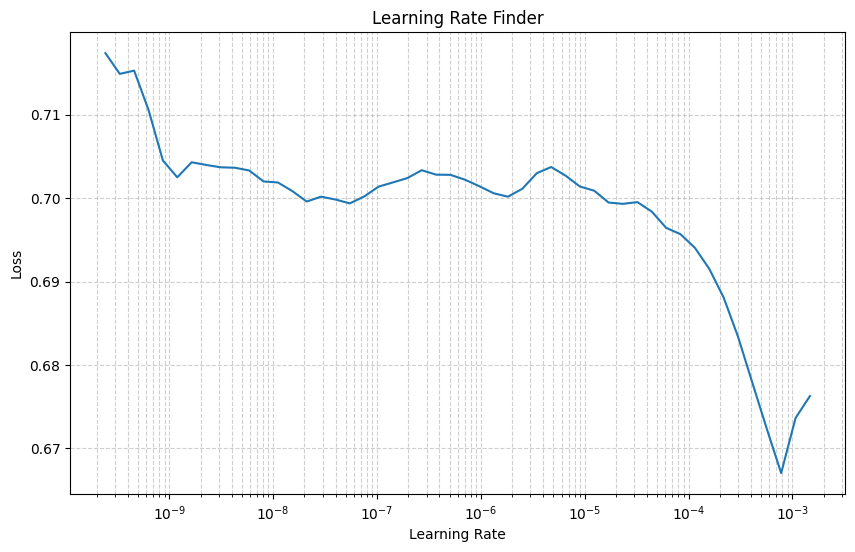

In [19]:
# Visualización
fig, ax = lr_finder.plot_loss()
plt.show()

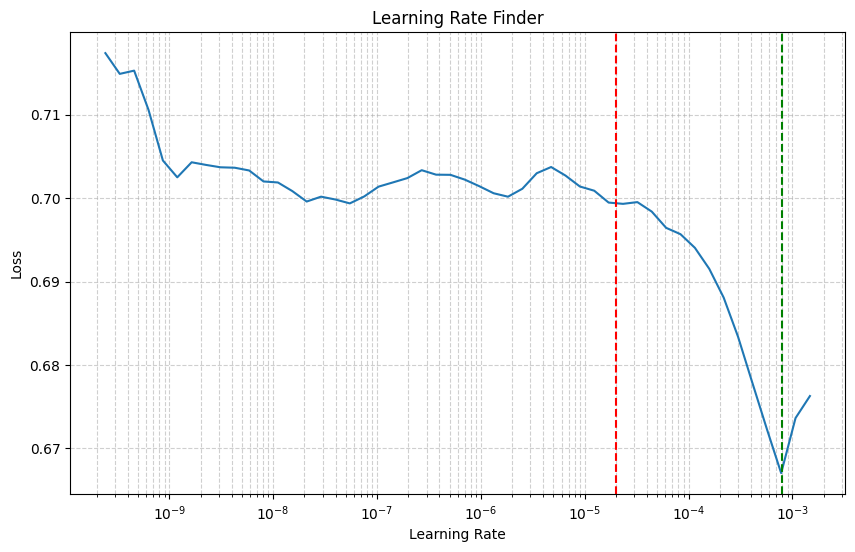

In [20]:
# Visualización
min_lr = 2e-5
max_lr = 8e-4
fig, ax = lr_finder.plot_loss()
ax.axvline(min_lr, color='r', linestyle='--', label='min_lr')
ax.axvline(max_lr, color='g', linestyle='--', label='max_lr')
plt.show()

### One Cycle Policy

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [22]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

### Training

In [23]:
history, history_full = train_with_checkpoints(
    model_1,
    train_dataset,
    val_dataset,
    epochs=epochs,
    checkpoint_dir="checkpoints/i3d_model_1",
    one_cycle_scheduler=one_cycle_scheduler
)

Starting training from scratch.
Epoch 1/40


2025-04-21 14:56:57.527719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-21 14:57:07.802094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 14:57:17.432346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 120 of 516
2025-04-21 14:57:27.473593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 149 of 516
2025-04-21 14:57:37.464036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 179 of 516
2025-04-21 14:57:47.701264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-21 14:57:57.505171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-21 14:58:07.398046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 280 of 516
2025-04-21 14:58:17.431569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 151s 254ms/step - loss: 0.6358 - accuracy: 0.6458 - auc: 0.7467WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1174s vs `on_train_batch_end` time: 0.1360s). Check your callbacks.
65/65 [==============================] - 232s 1s/step - loss: 0.9168 - accuracy: 0.5523 - auc: 0.5467 - val_loss: 0.7313 - val_accuracy: 0.6615 - val_auc: 0.6611
Epoch 2/40


2025-04-21 15:00:52.959446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-21 15:01:02.938664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:01:12.893108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 103 of 516
2025-04-21 15:01:22.850144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 132 of 516
2025-04-21 15:01:33.232848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 152 of 516
2025-04-21 15:01:43.622484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-21 15:01:53.158122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-21 15:02:02.914624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-21 15:02:12.846129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 247s 730ms/step - loss: 0.7118 - accuracy: 0.5930 - auc: 0.5961 - val_loss: 0.6048 - val_accuracy: 0.7538 - val_auc: 0.7959
Epoch 3/40


2025-04-21 15:05:13.974735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 25 of 516
2025-04-21 15:05:23.803035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 61 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:05:33.841240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 99 of 516
2025-04-21 15:05:43.974373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 127 of 516
2025-04-21 15:05:54.420493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-21 15:06:03.727728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 162 of 516
2025-04-21 15:06:14.013521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-21 15:06:23.961690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-21 15:06:33.675701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (

65/65 [==============================] - 321s 1s/step - loss: 0.6582 - accuracy: 0.6105 - auc: 0.6530 - val_loss: 0.6045 - val_accuracy: 0.6769 - val_auc: 0.7509
Epoch 4/40


2025-04-21 15:10:46.758707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8 of 516
2025-04-21 15:10:56.880116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 18 of 516
2025-04-21 15:11:07.196932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 516
2025-04-21 15:11:17.618735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38 of 516
2025-04-21 15:11:27.521017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 52 of 516
2025-04-21 15:11:36.746373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 64 of 516
2025-04-21 15:11:47.131668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this m

Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:11:56.498450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 104 of 516
2025-04-21 15:12:06.782378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 131 of 516
2025-04-21 15:12:16.603789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 151 of 516
2025-04-21 15:12:26.641761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-21 15:12:36.799783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 198 of 516
2025-04-21 15:12:47.570590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-21 15:12:57.379636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 386s 714ms/step - loss: 0.6352 - accuracy: 0.6570 - auc: 0.6935 - val_loss: 0.5845 - val_accuracy: 0.6769 - val_auc: 0.7721
Epoch 5/40


2025-04-21 15:17:22.488066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 27 of 516
2025-04-21 15:17:32.206787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 54 of 516
2025-04-21 15:17:42.203287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 90 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:17:52.000845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 126 of 516
2025-04-21 15:18:01.933144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-21 15:18:12.367751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-21 15:18:22.333097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-21 15:18:32.120675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 155 of 516
2025-04-21 15:18:42.014292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 161 of 516
2025-04-21 15:18:52.043960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 312s 569ms/step - loss: 0.6202 - accuracy: 0.6822 - auc: 0.7232 - val_loss: 0.5621 - val_accuracy: 0.7077 - val_auc: 0.7841
Epoch 6/40


2025-04-21 15:22:37.382741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-21 15:22:47.425765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:22:57.635387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-21 15:23:07.360111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-21 15:23:17.528157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-21 15:23:27.570272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 202 of 516
2025-04-21 15:23:37.450302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-21 15:23:47.374022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 262 of 516
2025-04-21 15:23:57.503002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 562ms/step - loss: 0.6303 - accuracy: 0.6802 - auc: 0.7180 - val_loss: 0.6180 - val_accuracy: 0.7077 - val_auc: 0.7256
Epoch 7/40


2025-04-21 15:25:55.109591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-21 15:26:05.116170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 75 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:26:15.092536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 109 of 516
2025-04-21 15:26:25.129587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 140 of 516
2025-04-21 15:26:35.335846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-21 15:26:45.065399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 200 of 516
2025-04-21 15:26:55.174762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 227 of 516
2025-04-21 15:27:05.205077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 260 of 516
2025-04-21 15:27:15.014198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 198s 563ms/step - loss: 0.6407 - accuracy: 0.6473 - auc: 0.6948 - val_loss: 0.5926 - val_accuracy: 0.6769 - val_auc: 0.7529
Epoch 8/40


2025-04-21 15:29:14.593041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-21 15:29:24.761093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:29:34.532249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-21 15:29:44.978135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-21 15:29:54.588538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-21 15:30:04.403376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-21 15:30:14.414882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 229 of 516
2025-04-21 15:30:24.558623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 261 of 516
2025-04-21 15:30:34.705261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 204s 577ms/step - loss: 0.6252 - accuracy: 0.6531 - auc: 0.7144 - val_loss: 0.6374 - val_accuracy: 0.6769 - val_auc: 0.6967
Epoch 9/40


2025-04-21 15:32:40.927574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 33 of 516
2025-04-21 15:32:50.642160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 71 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:33:00.823279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-21 15:33:10.840907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-21 15:33:20.651842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 158 of 516
2025-04-21 15:33:30.595523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 186 of 516
2025-04-21 15:33:40.841293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-21 15:33:50.635765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 243 of 516
2025-04-21 15:34:00.661905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 207s 545ms/step - loss: 0.6488 - accuracy: 0.6667 - auc: 0.6901 - val_loss: 0.6304 - val_accuracy: 0.6769 - val_auc: 0.7070
Epoch 10/40


2025-04-21 15:36:09.614588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-21 15:36:19.660612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:36:29.510228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-21 15:36:39.644024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 147 of 516
2025-04-21 15:36:49.768162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-21 15:36:59.715902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 213 of 516
2025-04-21 15:37:09.635219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 243 of 516
2025-04-21 15:37:19.744358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 275 of 516
2025-04-21 15:37:29.698856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 189s 550ms/step - loss: 0.6316 - accuracy: 0.6434 - auc: 0.7047 - val_loss: 0.5863 - val_accuracy: 0.6923 - val_auc: 0.7662
Epoch 11/40


2025-04-21 15:39:20.644269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-21 15:39:30.531855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:39:40.541289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-21 15:39:50.726762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-21 15:40:00.606943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 174 of 516
2025-04-21 15:40:10.585656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 209 of 516
2025-04-21 15:40:20.592590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 238 of 516
2025-04-21 15:40:30.551358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 271 of 516
2025-04-21 15:40:40.697448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 191s 552ms/step - loss: 0.6646 - accuracy: 0.6318 - auc: 0.6824 - val_loss: 0.6087 - val_accuracy: 0.6769 - val_auc: 0.7217
Epoch 12/40


2025-04-21 15:42:33.179083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-21 15:42:43.093426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:42:53.178916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-21 15:43:03.220695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 145 of 516
2025-04-21 15:43:13.592770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-21 15:43:23.226992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 212 of 516
2025-04-21 15:43:33.121545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 241 of 516
2025-04-21 15:43:43.284012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 274 of 516
2025-04-21 15:43:53.134796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 189s 549ms/step - loss: 0.6472 - accuracy: 0.6628 - auc: 0.7011 - val_loss: 0.5175 - val_accuracy: 0.7538 - val_auc: 0.8187
Epoch 13/40


2025-04-21 15:45:45.665144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-21 15:45:55.695301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:46:05.814148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-21 15:46:15.706719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 144 of 516
2025-04-21 15:46:25.745775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 175 of 516
2025-04-21 15:46:35.765838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 210 of 516
2025-04-21 15:46:45.684802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 238 of 516
2025-04-21 15:46:55.821245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 272 of 516
2025-04-21 15:47:05.894871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 190s 549ms/step - loss: 0.6031 - accuracy: 0.6705 - auc: 0.7467 - val_loss: 0.5092 - val_accuracy: 0.7538 - val_auc: 0.8360
Epoch 14/40


2025-04-21 15:48:58.808558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-21 15:49:08.835476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:49:18.838232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-21 15:49:29.109348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-21 15:49:38.766918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-21 15:49:48.958789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-21 15:49:58.977937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 236 of 516
2025-04-21 15:50:08.899891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 269 of 516
2025-04-21 15:50:19.162030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 192s 547ms/step - loss: 0.6039 - accuracy: 0.6667 - auc: 0.7386 - val_loss: 0.5722 - val_accuracy: 0.7385 - val_auc: 0.7955
Epoch 15/40


2025-04-21 15:52:12.768250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-21 15:52:22.715957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:52:32.647226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-21 15:52:42.715770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 145 of 516
2025-04-21 15:52:52.634776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 176 of 516
2025-04-21 15:53:02.675496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 211 of 516
2025-04-21 15:53:12.661630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 240 of 516
2025-04-21 15:53:22.646824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 273 of 516
2025-04-21 15:53:32.784338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 190s 549ms/step - loss: 0.5994 - accuracy: 0.6880 - auc: 0.7423 - val_loss: 0.5762 - val_accuracy: 0.6615 - val_auc: 0.7792
Epoch 16/40


2025-04-21 15:55:24.148073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-21 15:55:34.230324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:55:44.256921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-21 15:55:54.155842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 144 of 516
2025-04-21 15:56:04.309220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 175 of 516
2025-04-21 15:56:14.274213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 210 of 516
2025-04-21 15:56:24.224061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 238 of 516
2025-04-21 15:56:34.263944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 271 of 516
2025-04-21 15:56:44.444049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 221s 713ms/step - loss: 0.6269 - accuracy: 0.6841 - auc: 0.7169 - val_loss: 0.5667 - val_accuracy: 0.7385 - val_auc: 0.7775
Epoch 17/40


2025-04-21 15:59:06.873695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 24 of 516
2025-04-21 15:59:16.677063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 51 of 516
2025-04-21 15:59:26.837623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 15:59:36.810994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 102 of 516
2025-04-21 15:59:47.607617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 132 of 516
2025-04-21 15:59:57.325817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 152 of 516
2025-04-21 16:00:07.484537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-21 16:00:17.088791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-21 16:00:27.335018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-21 16:00:37.297283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 283s 735ms/step - loss: 0.5623 - accuracy: 0.7112 - auc: 0.7839 - val_loss: 0.5770 - val_accuracy: 0.7077 - val_auc: 0.7903
Epoch 18/40


2025-04-21 16:03:51.659198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 22 of 516
2025-04-21 16:04:01.489907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 47 of 516
2025-04-21 16:04:11.701156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:04:21.515725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 98 of 516
2025-04-21 16:04:31.641573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 122 of 516
2025-04-21 16:04:41.732734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 140 of 516
2025-04-21 16:04:51.555052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 158 of 516
2025-04-21 16:05:01.432787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-21 16:05:11.560481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 198 of 516
2025-04-21 16:05:22.315267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (

65/65 [==============================] - 303s 762ms/step - loss: 0.5830 - accuracy: 0.6899 - auc: 0.7656 - val_loss: 0.6094 - val_accuracy: 0.7538 - val_auc: 0.7709
Epoch 19/40


2025-04-21 16:08:56.184817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 16:09:06.197287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 44 of 516
2025-04-21 16:09:16.413841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516
2025-04-21 16:09:26.212611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 92 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:09:36.458475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-21 16:09:46.401129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 133 of 516
2025-04-21 16:09:56.576166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-21 16:10:06.279430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 164 of 516
2025-04-21 16:10:16.163384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 183 of 516
2025-04-21 16:10:26.335098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-21 16:10:36.782749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 302s 712ms/step - loss: 0.5613 - accuracy: 0.7229 - auc: 0.7860 - val_loss: 0.5643 - val_accuracy: 0.7692 - val_auc: 0.7754
Epoch 20/40


2025-04-21 16:13:59.842198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 22 of 516
2025-04-21 16:14:09.356055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 47 of 516
2025-04-21 16:14:19.452556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:14:29.406934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 98 of 516
2025-04-21 16:14:39.511234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 123 of 516
2025-04-21 16:14:49.991222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-21 16:14:59.411154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 159 of 516
2025-04-21 16:15:10.043476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-21 16:15:19.451391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 199 of 516
2025-04-21 16:15:29.930127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (

65/65 [==============================] - 302s 766ms/step - loss: 0.5365 - accuracy: 0.7403 - auc: 0.8076 - val_loss: 0.4875 - val_accuracy: 0.7692 - val_auc: 0.8471
Epoch 21/40


2025-04-21 16:19:05.287743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 16:19:14.969457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 44 of 516
2025-04-21 16:19:25.196577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516
2025-04-21 16:19:35.047988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 93 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:19:45.135966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-21 16:19:55.242809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-21 16:20:05.651750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-21 16:20:15.016934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-21 16:20:25.074143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 193 of 516
2025-04-21 16:20:35.476975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-21 16:20:45.291939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 297s 745ms/step - loss: 0.5489 - accuracy: 0.7384 - auc: 0.7978 - val_loss: 0.5502 - val_accuracy: 0.7231 - val_auc: 0.7986
Epoch 22/40


2025-04-21 16:24:04.588144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 22 of 516
2025-04-21 16:24:14.312746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 46 of 516
2025-04-21 16:24:24.059505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 74 of 516
2025-04-21 16:24:34.390892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 96 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:24:44.807572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-21 16:24:53.911741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 138 of 516
2025-04-21 16:25:03.927177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-21 16:25:14.248894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 172 of 516
2025-04-21 16:25:24.013178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 193 of 516
2025-04-21 16:25:33.979175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-21 16:25:44.141583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 298s 748ms/step - loss: 0.5659 - accuracy: 0.7267 - auc: 0.7815 - val_loss: 0.5461 - val_accuracy: 0.7385 - val_auc: 0.7981
Epoch 23/40


2025-04-21 16:29:03.623298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 23 of 516
2025-04-21 16:29:13.832164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 48 of 516
2025-04-21 16:29:23.700984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 75 of 516
2025-04-21 16:29:33.643365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 96 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:29:43.750368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 122 of 516
2025-04-21 16:29:53.613108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 139 of 516
2025-04-21 16:30:03.946120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-21 16:30:13.758754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 172 of 516
2025-04-21 16:30:23.621193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 193 of 516
2025-04-21 16:30:33.737549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-21 16:30:43.918109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 298s 733ms/step - loss: 0.5028 - accuracy: 0.7674 - auc: 0.8352 - val_loss: 0.5570 - val_accuracy: 0.6923 - val_auc: 0.8031
Epoch 24/40


2025-04-21 16:34:25.908233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 16:34:35.669884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 43 of 516
2025-04-21 16:34:45.764498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516
2025-04-21 16:34:56.179147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 93 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:35:05.897204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-21 16:35:15.752758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-21 16:35:25.643688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 153 of 516
2025-04-21 16:35:35.812716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-21 16:35:45.864383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 192 of 516
2025-04-21 16:35:56.047416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-21 16:36:05.709402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 301s 768ms/step - loss: 0.5262 - accuracy: 0.7384 - auc: 0.8163 - val_loss: 0.5196 - val_accuracy: 0.7385 - val_auc: 0.8241
Epoch 25/40


2025-04-21 16:39:48.022879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 22 of 516
2025-04-21 16:39:57.982592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 46 of 516
2025-04-21 16:40:07.942136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 74 of 516
2025-04-21 16:40:17.666888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 94 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:40:27.541344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 118 of 516
2025-04-21 16:40:37.626061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 136 of 516
2025-04-21 16:40:48.518102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-21 16:40:57.755224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-21 16:41:07.475549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-21 16:41:18.220761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-21 16:41:27.445556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 299s 722ms/step - loss: 0.5026 - accuracy: 0.7674 - auc: 0.8372 - val_loss: 0.6081 - val_accuracy: 0.7231 - val_auc: 0.8089
Epoch 26/40


2025-04-21 16:44:48.198228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 16:44:58.413379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 46 of 516
2025-04-21 16:45:08.624023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 74 of 516
2025-04-21 16:45:18.768288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 96 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:45:29.158215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-21 16:45:38.451409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 138 of 516
2025-04-21 16:45:48.911116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-21 16:45:58.326643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 172 of 516
2025-04-21 16:46:08.176777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 194 of 516
2025-04-21 16:46:18.704892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-21 16:46:28.485310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 298s 754ms/step - loss: 0.5061 - accuracy: 0.7694 - auc: 0.8309 - val_loss: 0.5364 - val_accuracy: 0.7538 - val_auc: 0.8088
Epoch 27/40


2025-04-21 16:49:48.009693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 22 of 516
2025-04-21 16:49:57.698775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 46 of 516
2025-04-21 16:50:07.616118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 74 of 516
2025-04-21 16:50:17.679129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 95 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:50:27.494587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-21 16:50:37.734819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 138 of 516
2025-04-21 16:50:47.905295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-21 16:50:57.663780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-21 16:51:07.804789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 193 of 516
2025-04-21 16:51:18.225142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-21 16:51:27.954753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 303s 759ms/step - loss: 0.4774 - accuracy: 0.7829 - auc: 0.8531 - val_loss: 0.5831 - val_accuracy: 0.7077 - val_auc: 0.7923
Epoch 28/40


2025-04-21 16:54:52.232832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 16:55:02.211136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 45 of 516
2025-04-21 16:55:12.265546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 73 of 516
2025-04-21 16:55:22.437576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 96 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 16:55:32.707529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-21 16:55:42.946147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 140 of 516
2025-04-21 16:55:52.403441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 156 of 516
2025-04-21 16:56:02.406228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 176 of 516
2025-04-21 16:56:12.346115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 196 of 516
2025-04-21 16:56:23.298721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-21 16:56:32.546966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 291s 724ms/step - loss: 0.4425 - accuracy: 0.8062 - auc: 0.8755 - val_loss: 0.5577 - val_accuracy: 0.7385 - val_auc: 0.8232
Epoch 29/40


2025-04-21 16:59:45.283629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 31 of 516
2025-04-21 16:59:55.480975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 59 of 516
2025-04-21 17:00:05.514507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 85 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:00:15.516461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 105 of 516
2025-04-21 17:00:25.633863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 130 of 516
2025-04-21 17:00:35.573311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 145 of 516
2025-04-21 17:00:45.502756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 163 of 516
2025-04-21 17:00:55.461846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 183 of 516
2025-04-21 17:01:05.682946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-21 17:01:15.359166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 292s 740ms/step - loss: 0.4592 - accuracy: 0.7868 - auc: 0.8646 - val_loss: 0.5704 - val_accuracy: 0.7077 - val_auc: 0.8064
Epoch 30/40


2025-04-21 17:04:39.540831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 22 of 516
2025-04-21 17:04:49.332085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 46 of 516
2025-04-21 17:04:58.832290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 73 of 516
2025-04-21 17:05:08.918264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 95 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:05:18.750023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 119 of 516
2025-04-21 17:05:29.064079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 138 of 516
2025-04-21 17:05:39.129303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-21 17:05:48.809114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-21 17:05:58.758070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 193 of 516
2025-04-21 17:06:08.757876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-21 17:06:19.421985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 298s 754ms/step - loss: 0.4331 - accuracy: 0.7946 - auc: 0.8825 - val_loss: 0.5348 - val_accuracy: 0.7231 - val_auc: 0.8234
Epoch 31/40


2025-04-21 17:09:38.595214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 17:09:48.534221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 45 of 516
2025-04-21 17:09:58.490042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516
2025-04-21 17:10:08.583770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 95 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:10:19.139712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-21 17:10:28.911992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 140 of 516
2025-04-21 17:10:38.766418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 157 of 516
2025-04-21 17:10:48.763956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 175 of 516
2025-04-21 17:10:58.541344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 195 of 516
2025-04-21 17:11:08.459058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-21 17:11:18.692206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 297s 774ms/step - loss: 0.4470 - accuracy: 0.7946 - auc: 0.8730 - val_loss: 0.5314 - val_accuracy: 0.7692 - val_auc: 0.8331
Epoch 32/40


2025-04-21 17:14:36.875598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 20 of 516
2025-04-21 17:14:46.997238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 42 of 516
2025-04-21 17:14:56.734074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 67 of 516
2025-04-21 17:15:06.973261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 91 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:15:16.838555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-21 17:15:27.481092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 134 of 516
2025-04-21 17:15:36.727875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 150 of 516
2025-04-21 17:15:47.276600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-21 17:15:57.018493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 188 of 516
2025-04-21 17:16:06.775684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 206 of 516
2025-04-21 17:16:17.205585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 312s 741ms/step - loss: 0.4475 - accuracy: 0.7771 - auc: 0.8722 - val_loss: 0.5334 - val_accuracy: 0.7538 - val_auc: 0.8245
Epoch 33/40


2025-04-21 17:19:51.061261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 17:20:00.989578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 44 of 516
2025-04-21 17:20:10.927751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 70 of 516
2025-04-21 17:20:21.144401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 93 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:20:31.149826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-21 17:20:40.937260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 135 of 516
2025-04-21 17:20:51.186479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 153 of 516
2025-04-21 17:21:00.986096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-21 17:21:11.172583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-21 17:21:20.983139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 213 of 516
2025-04-21 17:21:30.874408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 299s 762ms/step - loss: 0.3985 - accuracy: 0.8314 - auc: 0.9024 - val_loss: 0.5565 - val_accuracy: 0.7077 - val_auc: 0.8200
Epoch 34/40


2025-04-21 17:24:51.672397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 17:25:01.604600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 43 of 516
2025-04-21 17:25:11.882058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 72 of 516
2025-04-21 17:25:22.279885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 93 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:25:31.749918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-21 17:25:41.794157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 133 of 516
2025-04-21 17:25:51.716524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-21 17:26:01.897563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 166 of 516
2025-04-21 17:26:11.853638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 186 of 516
2025-04-21 17:26:21.848511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 204 of 516
2025-04-21 17:26:31.616727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 311s 775ms/step - loss: 0.3783 - accuracy: 0.8391 - auc: 0.9143 - val_loss: 0.5421 - val_accuracy: 0.7385 - val_auc: 0.8301
Epoch 35/40


2025-04-21 17:30:04.889213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 17:30:14.597996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 42 of 516
2025-04-21 17:30:24.728259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 69 of 516
2025-04-21 17:30:34.645481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 92 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:30:44.740031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-21 17:30:54.636084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 132 of 516
2025-04-21 17:31:04.618002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-21 17:31:15.132107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-21 17:31:24.960105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 188 of 516
2025-04-21 17:31:34.640991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 204 of 516
2025-04-21 17:31:45.165649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 321s 793ms/step - loss: 0.3996 - accuracy: 0.8159 - auc: 0.9000 - val_loss: 0.5692 - val_accuracy: 0.7231 - val_auc: 0.8154


### Evolución del Learning rate

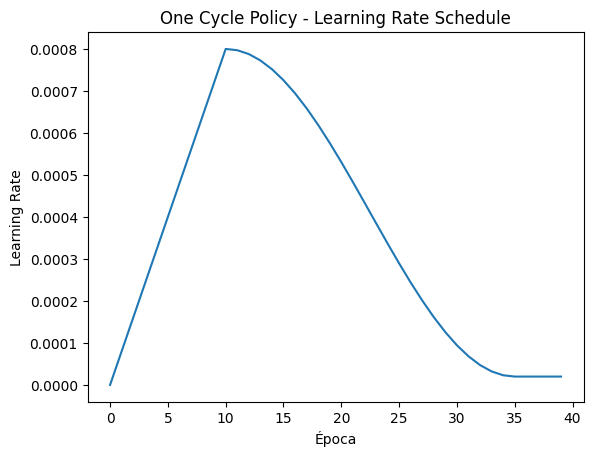

In [24]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [25]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-04-21 17:35:28.257475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 21 of 516
2025-04-21 17:35:38.250243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 42 of 516
2025-04-21 17:35:48.364331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 66 of 516
2025-04-21 17:35:57.885033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 88 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-21 17:36:08.194732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 110 of 516
2025-04-21 17:36:19.392366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 132 of 516
2025-04-21 17:36:28.079688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 151 of 516
2025-04-21 17:36:38.738664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-21 17:36:48.197040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 185 of 516
2025-04-21 17:36:58.255219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-21 17:37:07.911104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 277s 147ms/step - loss: 0.5670 - accuracy: 0.7112 - auc: 0.7826


In [26]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 34s 4s/step - loss: 0.4875 - accuracy: 0.7692 - auc: 0.8471


In [27]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 37s 4s/step - loss: 0.6901 - accuracy: 0.6308 - auc: 0.6499


In [28]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.5669595003128052, Accuracy: 0.711240291595459
Val - Loss: 0.4875437319278717, Accuracy: 0.7692307829856873
Test - Loss: 0.6900961399078369, Accuracy: 0.6307692527770996


### Gráficas de entrenamiento y validación

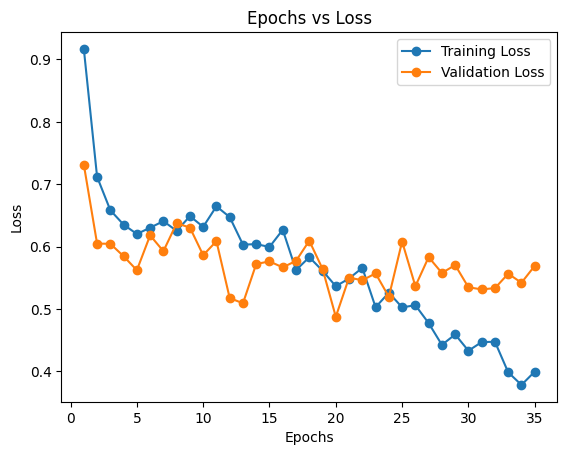

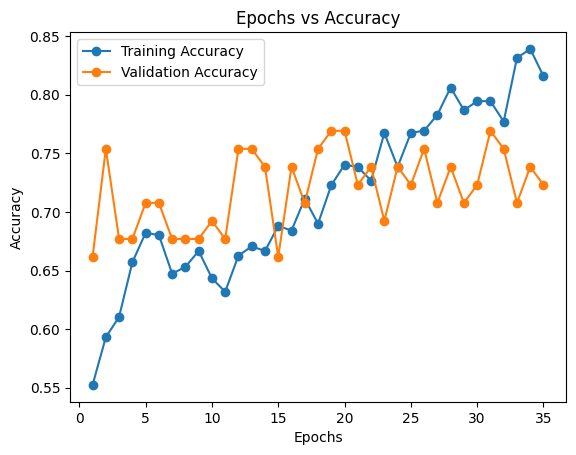

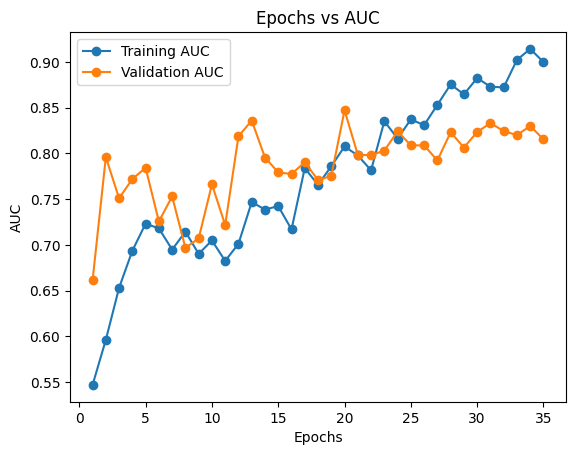

In [29]:
plot_loss(history_full)
plot_accuracy(history_full)
plot_auc(history_full)

### Visualización del Modelo con TSNE

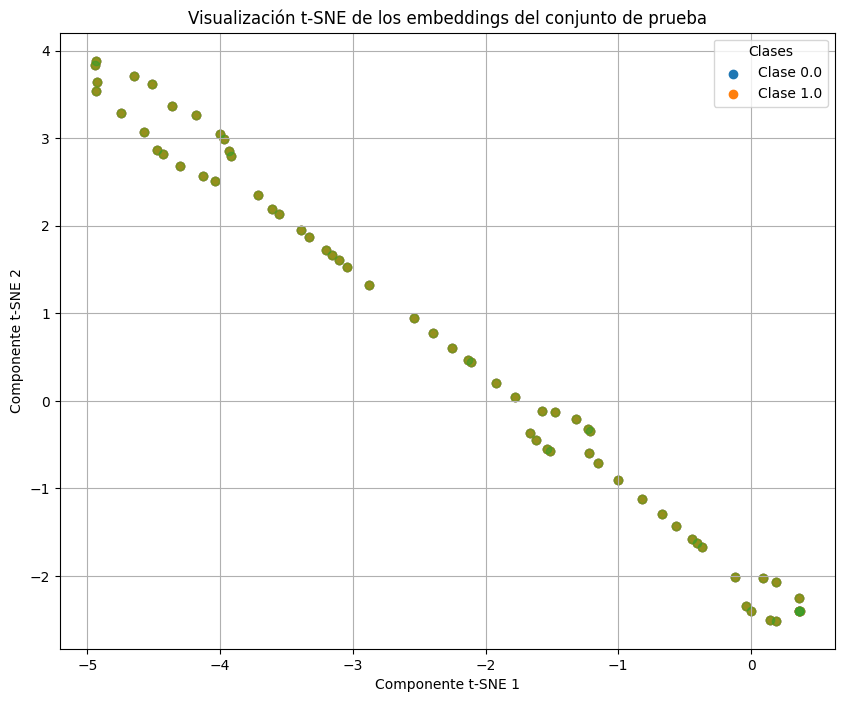

In [30]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], alpha=0.5)
plt.show()

## I3D + ConvLSTM2D

In [16]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### Elección de hiperparametros

In [17]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import Model
from tensorflow.keras.layers import (ConvLSTM2D, Dense, GlobalAveragePooling2D,
                                     Dropout, BatchNormalization)
from tensorflow.keras.metrics import AUC
import tensorflow as tf

# Supón que ya tienes importado InceptionI3d

def build_model(hp):
    class Tuned_I3D_ConvLSTM(Model):
        def __init__(self, num_classes):
            super().__init__()
            self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint="Mixed_5c")

            # Convertimos las opciones de kernel_size en strings y las evaluamos después
            kernel_size_choice = hp.Choice('kernel_size', ['3x3', '5x5'])
            if kernel_size_choice == '3x3':
                kernel_size = (3, 3)
            else:
                kernel_size = (5, 5)

            self.conv_lstm = ConvLSTM2D(
                filters=hp.Choice('filters', [32, 64, 128]),
                kernel_size=kernel_size,
                padding='same',
                return_sequences=False,
                dropout=hp.Choice('dropout', [0.2, 0.3, 0.5]),
                recurrent_dropout=hp.Choice('recurrent_dropout', [0.2, 0.3, 0.5]),
                activation='tanh'
            )

            self.batch_norm = BatchNormalization()
            self.dense = Dense(hp.Choice('dense_units', [64, 128, 256]), activation='relu')
            self.dropout = Dropout(hp.Choice('dense_dropout', [0.2, 0.3, 0.5]))
            self.fc = Dense(num_classes, activation='sigmoid')

        def call(self, inputs, training=False):
            features, _ = self.i3d(inputs)
            x = self.conv_lstm(features)
            x = self.batch_norm(x, training=training)
            x = GlobalAveragePooling2D()(x)
            x = self.dense(x)
            x = self.dropout(x, training=training)
            return self.fc(x)

    num_classes = 2
    model = Tuned_I3D_ConvLSTM(num_classes=num_classes)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
    return model


/tmp/ipykernel_2187173/707598854.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [18]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='i3d_convlstm_tuning'
)

# Muestra resumen de los hiperparámetros buscados
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project tuner_logs/i3d_convlstm_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_logs/i3d_convlstm_tuning/tuner0.json
Search space summary
Default search space size: 6
kernel_size (Choice)
{'default': '3x3', 'conditions': [], 'values': ['3x3', '5x5'], 'ordered': False}
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}
recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}
dense_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dense_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.5], 'ordered': True}


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_dataset, 
             epochs=10, 
             validation_data=val_dataset, 
             callbacks=[early_stopping], 
             verbose=1)

INFO:tensorflow:Oracle triggered exit


In [20]:
# Obtener los 3 mejores hiperparámetros encontrados por el tuner
best_hps = tuner.get_best_hyperparameters(num_trials=3)

# Mostrar los mejores hiperparámetros
for i, hps in enumerate(best_hps, 1):
    print(f"\nMejores hiperparámetros #{i}:")
    for param in hps.values.keys():
        print(f"  {param}: {hps.get(param)}")




Mejores hiperparámetros #1:
  kernel_size: 3x3
  filters: 128
  dropout: 0.3
  recurrent_dropout: 0.5
  dense_units: 128
  dense_dropout: 0.5

Mejores hiperparámetros #2:
  kernel_size: 3x3
  filters: 64
  dropout: 0.5
  recurrent_dropout: 0.3
  dense_units: 256
  dense_dropout: 0.2

Mejores hiperparámetros #3:
  kernel_size: 3x3
  filters: 128
  dropout: 0.2
  recurrent_dropout: 0.3
  dense_units: 64
  dense_dropout: 0.5


In [21]:
# Guardar en variables los valores del mejor modelo (el primero de la lista)
best_hp = best_hps[0]
kernel_size = best_hp.get('kernel_size')
filters = best_hp.get('filters')
dropout = best_hp.get('dropout')
recurrent_dropout = best_hp.get('recurrent_dropout')
dense_units = best_hp.get('dense_units')
dense_dropout = best_hp.get('dense_dropout')

### Modelo

In [22]:
initial_learning_rate = 1e-7

In [23]:
# Obtener el mejor conjunto de hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Reconstruir el modelo usando los mejores hiperparámetros
model_2 = build_model(best_hp)

# Compilar el modelo (esto ya se hace dentro de build_model, pero puedes asegurarte aquí)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", AUC(name="auc")])

In [35]:
epochs = 60  # Número de épocas
initial_learning_rate = 1e-15
num_classes = 2

In [38]:
# Instanciar el LRFinder
lr_finder = LRFinder(min_lr=initial_learning_rate, max_lr=5e-3, steps=65, smoothing=0.5)
# Ejecutar el LRFinder sobre un subconjunto del dataset (mejor si es un subconjunto pequeño)
model_2.fit(
    train_dataset.take(200),  # puedes ajustar este valor según el tamaño de tus batches
    epochs=1,
    callbacks=[lr_finder]
)


2025-04-22 00:21:57.899849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-22 00:22:08.014514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:22:18.164232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-22 00:22:27.832264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 150 of 516
2025-04-22 00:22:37.835999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 180 of 516
2025-04-22 00:22:47.835607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-22 00:22:58.133276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-22 00:23:08.001920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 281 of 516
2025-04-22 00:23:17.834405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 168s 276ms/step - loss: 0.7232 - accuracy: 0.4583 - auc: 0.4290WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1352s vs `on_train_batch_end` time: 0.1406s). Check your callbacks.
65/65 [==============================] - 184s 273ms/step - loss: 0.7081 - accuracy: 0.5019 - auc: 0.5196


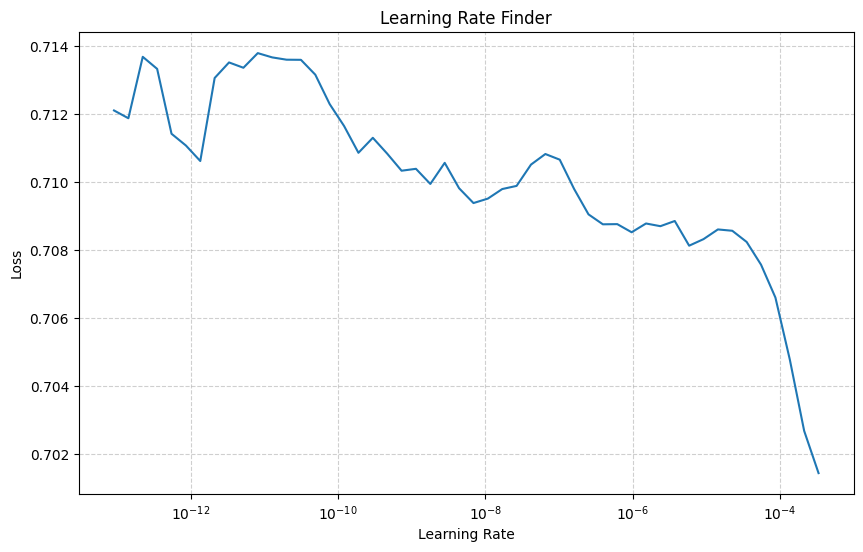

In [39]:
# Visualización
fig, ax = lr_finder.plot_loss()
plt.show()

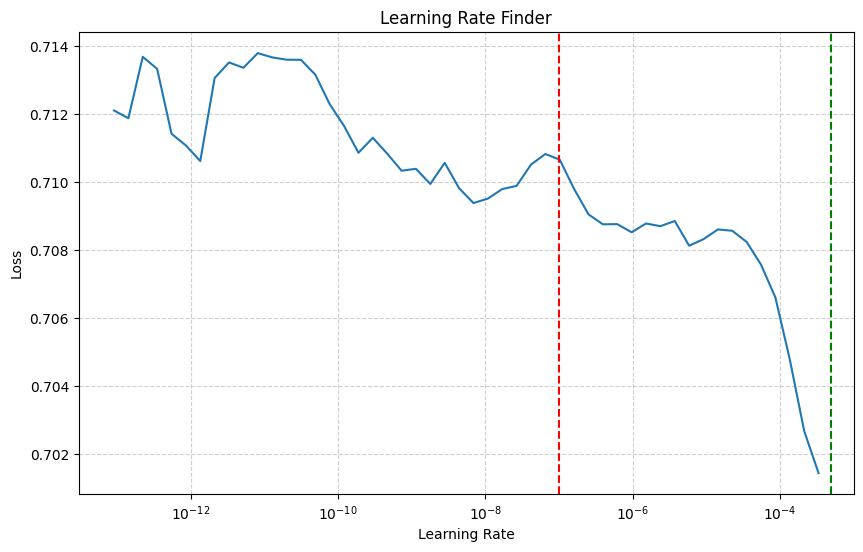

In [40]:
# Visualización
min_lr = 1e-7
max_lr = 5e-4
fig, ax = lr_finder.plot_loss()
ax.axvline(min_lr, color='r', linestyle='--', label='min_lr')
ax.axvline(max_lr, color='g', linestyle='--', label='max_lr')
plt.show()

In [42]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

In [43]:
history2, history_full2 = train_with_checkpoints(
    model_2,
    train_dataset,
    val_dataset,
    epochs=epochs,
    checkpoint_dir="checkpoints/i3d_convlstm_1",
    one_cycle_scheduler=one_cycle_scheduler
)

Starting training from scratch.
Epoch 1/60


2025-04-22 00:25:58.584336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 00:26:08.686064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:26:18.558632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-22 00:26:28.669375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 147 of 516
2025-04-22 00:26:38.593959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-22 00:26:49.083612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-22 00:26:58.582377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 244 of 516
2025-04-22 00:27:09.121903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 277 of 516
2025-04-22 00:27:18.713701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      6/Unknown - 153s 273ms/step - loss: 0.8532 - accuracy: 0.4792 - auc: 0.4861WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1340s vs `on_train_batch_end` time: 0.1393s). Check your callbacks.
65/65 [==============================] - 191s 620ms/step - loss: 0.8256 - accuracy: 0.5116 - auc: 0.5250 - val_loss: 0.7027 - val_accuracy: 0.5077 - val_auc: 0.5516
Epoch 2/60


2025-04-22 00:29:14.449473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 00:29:24.498413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 80 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:29:34.506505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-22 00:29:44.441111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 146 of 516
2025-04-22 00:29:54.588700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 177 of 516
2025-04-22 00:30:04.531989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 213 of 516
2025-04-22 00:30:14.771013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 244 of 516
2025-04-22 00:30:24.655201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 276 of 516
2025-04-22 00:30:34.746476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 188s 561ms/step - loss: 0.7246 - accuracy: 0.5698 - auc: 0.5836 - val_loss: 0.6446 - val_accuracy: 0.6154 - val_auc: 0.6959
Epoch 3/60


2025-04-22 00:32:27.715206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 00:32:37.787379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:32:47.735851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 118 of 516
2025-04-22 00:32:58.114836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-22 00:33:08.046209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-22 00:33:17.860322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-22 00:33:27.755736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 245 of 516
2025-04-22 00:33:37.675991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 277 of 516
2025-04-22 00:33:47.845929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 188s 563ms/step - loss: 0.6831 - accuracy: 0.5930 - auc: 0.6240 - val_loss: 0.6573 - val_accuracy: 0.6769 - val_auc: 0.6676
Epoch 4/60


2025-04-22 00:35:37.528100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-22 00:35:47.676071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:35:57.891097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-22 00:36:07.424508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 149 of 516
2025-04-22 00:36:17.536634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 180 of 516
2025-04-22 00:36:27.520009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-22 00:36:37.712298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 247 of 516
2025-04-22 00:36:47.630358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 281 of 516
2025-04-22 00:36:57.463235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 186s 559ms/step - loss: 0.6330 - accuracy: 0.6705 - auc: 0.6972 - val_loss: 0.6132 - val_accuracy: 0.6923 - val_auc: 0.7418
Epoch 5/60


2025-04-22 00:38:49.442460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-22 00:38:59.681480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:39:09.945111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-22 00:39:19.558632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 149 of 516
2025-04-22 00:39:29.591644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 179 of 516
2025-04-22 00:39:39.919806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 215 of 516
2025-04-22 00:39:49.704765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 246 of 516
2025-04-22 00:39:59.534843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 279 of 516
2025-04-22 00:40:09.681995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 187s 562ms/step - loss: 0.6463 - accuracy: 0.6298 - auc: 0.6792 - val_loss: 0.5841 - val_accuracy: 0.7077 - val_auc: 0.7675
Epoch 6/60


2025-04-22 00:42:00.939436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 00:42:10.950952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 81 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:42:20.796802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 117 of 516
2025-04-22 00:42:31.235072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 148 of 516
2025-04-22 00:42:41.347483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 178 of 516
2025-04-22 00:42:51.237186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 214 of 516
2025-04-22 00:43:00.826944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 243 of 516
2025-04-22 00:43:11.033592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 274 of 516
2025-04-22 00:43:20.990068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 577ms/step - loss: 0.6416 - accuracy: 0.6202 - auc: 0.6854 - val_loss: 0.6125 - val_accuracy: 0.6769 - val_auc: 0.7305
Epoch 7/60


2025-04-22 00:45:17.780367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 00:45:27.684865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:45:37.820477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 00:45:47.659149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 00:45:58.103367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 00:46:08.061814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 00:46:17.612892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 227 of 516
2025-04-22 00:46:27.648868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 260 of 516
2025-04-22 00:46:37.899170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 575ms/step - loss: 0.6176 - accuracy: 0.6783 - auc: 0.7307 - val_loss: 0.6114 - val_accuracy: 0.6154 - val_auc: 0.7308
Epoch 8/60


2025-04-22 00:48:36.345909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 00:48:46.478258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:48:56.326777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 115 of 516
2025-04-22 00:49:06.533223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 00:49:16.419976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-22 00:49:26.589789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-22 00:49:36.601991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 236 of 516
2025-04-22 00:49:46.562028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 269 of 516
2025-04-22 00:49:56.894887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 195s 585ms/step - loss: 0.6075 - accuracy: 0.6395 - auc: 0.7254 - val_loss: 0.6058 - val_accuracy: 0.7385 - val_auc: 0.7530
Epoch 9/60


2025-04-22 00:51:53.714751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 00:52:03.660197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:52:13.800154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 00:52:24.081252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 00:52:33.836428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 00:52:43.797693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 00:52:53.714838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 00:53:03.762640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 265 of 516
2025-04-22 00:53:13.841147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 584ms/step - loss: 0.5886 - accuracy: 0.6744 - auc: 0.7501 - val_loss: 0.5399 - val_accuracy: 0.7385 - val_auc: 0.8114
Epoch 10/60


2025-04-22 00:55:15.301914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 00:55:25.260345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 75 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 00:55:35.065999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 107 of 516
2025-04-22 00:55:45.594382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 140 of 516
2025-04-22 00:55:55.327370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 166 of 516
2025-04-22 00:56:05.200959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 196 of 516
2025-04-22 00:56:15.612463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 225 of 516
2025-04-22 00:56:25.343052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 255 of 516
2025-04-22 00:56:35.474751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 600s 588ms/step - loss: 0.5799 - accuracy: 0.6996 - auc: 0.7668 - val_loss: 0.5759 - val_accuracy: 0.7385 - val_auc: 0.7827
Epoch 11/60


2025-04-22 01:05:19.042425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:05:29.140857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:05:38.958923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 01:05:49.043464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:05:59.042177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-22 01:06:08.870018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 01:06:18.823991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 232 of 516
2025-04-22 01:06:28.802500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 266 of 516
2025-04-22 01:06:38.917771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 579ms/step - loss: 0.6081 - accuracy: 0.7035 - auc: 0.7463 - val_loss: 0.6976 - val_accuracy: 0.6462 - val_auc: 0.6516
Epoch 12/60


2025-04-22 01:08:38.217817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:08:48.363614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:08:58.060737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 01:09:08.129427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:09:18.251284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-22 01:09:28.212480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 204 of 516
2025-04-22 01:09:38.057720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 232 of 516
2025-04-22 01:09:48.338360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 267 of 516
2025-04-22 01:09:58.224195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 195s 581ms/step - loss: 0.6143 - accuracy: 0.6686 - auc: 0.7239 - val_loss: 0.5394 - val_accuracy: 0.7538 - val_auc: 0.8120
Epoch 13/60


2025-04-22 01:11:57.337099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 01:12:07.330619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:12:17.537535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 01:12:27.337292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 01:12:37.558463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 01:12:47.408218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 01:12:57.711501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 01:13:07.356028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 261 of 516
2025-04-22 01:13:17.794512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 575ms/step - loss: 0.6141 - accuracy: 0.6957 - auc: 0.7376 - val_loss: 0.5861 - val_accuracy: 0.7231 - val_auc: 0.7644
Epoch 14/60


2025-04-22 01:15:15.945218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 01:15:26.292795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:15:36.042760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 01:15:46.099053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:15:56.132214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-22 01:16:06.034471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 204 of 516
2025-04-22 01:16:16.098381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 233 of 516
2025-04-22 01:16:25.968219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 266 of 516
2025-04-22 01:16:36.001354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 577ms/step - loss: 0.5757 - accuracy: 0.7151 - auc: 0.7719 - val_loss: 0.5366 - val_accuracy: 0.7538 - val_auc: 0.8160
Epoch 15/60


2025-04-22 01:18:36.417850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:18:46.224560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:18:56.216911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 01:19:06.625722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:19:16.507716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 01:19:26.244719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 202 of 516
2025-04-22 01:19:36.331857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 01:19:46.435462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 265 of 516
2025-04-22 01:19:56.471756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 574ms/step - loss: 0.5814 - accuracy: 0.7035 - auc: 0.7660 - val_loss: 0.5774 - val_accuracy: 0.7385 - val_auc: 0.7819
Epoch 16/60


2025-04-22 01:21:54.109802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:22:04.230280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:22:13.935610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 01:22:23.958637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:22:34.017509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-22 01:22:44.018475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 204 of 516
2025-04-22 01:22:53.910534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 232 of 516
2025-04-22 01:23:03.901881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 265 of 516
2025-04-22 01:23:14.046205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 195s 575ms/step - loss: 0.5621 - accuracy: 0.7151 - auc: 0.7840 - val_loss: 0.6138 - val_accuracy: 0.6923 - val_auc: 0.7662
Epoch 17/60


2025-04-22 01:25:10.917470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:25:20.757881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:25:30.814227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 01:25:41.199523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:25:50.833013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 01:26:00.961277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 202 of 516
2025-04-22 01:26:10.839394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 01:26:20.963063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 264 of 516
2025-04-22 01:26:30.874057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 576ms/step - loss: 0.5971 - accuracy: 0.6977 - auc: 0.7502 - val_loss: 0.6254 - val_accuracy: 0.6615 - val_auc: 0.7070
Epoch 18/60


2025-04-22 01:28:29.478215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:28:39.580034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:28:49.363307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 01:28:59.738508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:29:09.526702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 01:29:19.645901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 01:29:29.378750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 01:29:39.373256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 263 of 516
2025-04-22 01:29:49.380067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 195s 575ms/step - loss: 0.5727 - accuracy: 0.7054 - auc: 0.7732 - val_loss: 0.5505 - val_accuracy: 0.7538 - val_auc: 0.7954
Epoch 19/60


2025-04-22 01:31:46.820066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:31:56.647774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:32:06.741722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 01:32:16.904507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:32:26.801574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 01:32:36.837962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 01:32:46.825350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 01:32:56.738620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 264 of 516
2025-04-22 01:33:06.667561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 574ms/step - loss: 0.5783 - accuracy: 0.7132 - auc: 0.7702 - val_loss: 0.6452 - val_accuracy: 0.7077 - val_auc: 0.6982
Epoch 20/60


2025-04-22 01:35:04.609837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:35:14.523314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:35:24.531142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-22 01:35:34.743529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 01:35:44.427389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 172 of 516
2025-04-22 01:35:54.559613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 206 of 516
2025-04-22 01:36:04.520496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 234 of 516
2025-04-22 01:36:14.593108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 267 of 516
2025-04-22 01:36:24.550820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 195s 576ms/step - loss: 0.5987 - accuracy: 0.7074 - auc: 0.7504 - val_loss: 0.6376 - val_accuracy: 0.6615 - val_auc: 0.7226
Epoch 21/60


2025-04-22 01:38:21.982711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:38:32.073238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:38:41.899570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-22 01:38:52.453567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 01:39:02.032449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 172 of 516
2025-04-22 01:39:11.930082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 205 of 516
2025-04-22 01:39:21.932299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 234 of 516
2025-04-22 01:39:31.980061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 268 of 516
2025-04-22 01:39:42.417592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 572ms/step - loss: 0.5295 - accuracy: 0.7403 - auc: 0.8114 - val_loss: 0.6424 - val_accuracy: 0.7077 - val_auc: 0.7575
Epoch 22/60


2025-04-22 01:41:38.091578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:41:48.222793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:41:58.033523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-22 01:42:08.414376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 01:42:18.134126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 172 of 516
2025-04-22 01:42:27.991599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 205 of 516
2025-04-22 01:42:38.047935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 234 of 516
2025-04-22 01:42:48.082310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 267 of 516
2025-04-22 01:42:58.200190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 569ms/step - loss: 0.5464 - accuracy: 0.7326 - auc: 0.8060 - val_loss: 0.5836 - val_accuracy: 0.7385 - val_auc: 0.7996
Epoch 23/60


2025-04-22 01:44:54.081270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 01:45:04.138857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:45:14.268720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-22 01:45:24.026916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 01:45:33.997466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 174 of 516
2025-04-22 01:45:44.034716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 209 of 516
2025-04-22 01:45:54.205984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 238 of 516
2025-04-22 01:46:04.150132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 270 of 516
2025-04-22 01:46:14.240547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 573ms/step - loss: 0.5329 - accuracy: 0.7364 - auc: 0.8126 - val_loss: 0.5510 - val_accuracy: 0.7846 - val_auc: 0.7995
Epoch 24/60


2025-04-22 01:48:10.208882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:48:20.200476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:48:30.248214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-22 01:48:40.505833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 01:48:50.354716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 174 of 516
2025-04-22 01:49:00.292679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-22 01:49:10.300653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 236 of 516
2025-04-22 01:49:20.331455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 270 of 516
2025-04-22 01:49:30.225952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 193s 570ms/step - loss: 0.5134 - accuracy: 0.7597 - auc: 0.8312 - val_loss: 0.6171 - val_accuracy: 0.6308 - val_auc: 0.7335
Epoch 25/60


2025-04-22 01:51:25.150230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 01:51:35.034533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:51:44.951652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 115 of 516
2025-04-22 01:51:55.107858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 01:52:05.041687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-22 01:52:15.093518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 206 of 516
2025-04-22 01:52:25.081201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 235 of 516
2025-04-22 01:52:35.071284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 268 of 516
2025-04-22 01:52:45.182109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 573ms/step - loss: 0.5279 - accuracy: 0.7306 - auc: 0.8146 - val_loss: 0.5254 - val_accuracy: 0.7385 - val_auc: 0.8193
Epoch 26/60


2025-04-22 01:54:43.786334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:54:54.020716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:55:03.736152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 01:55:14.091607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:55:23.989771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 01:55:33.804990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 202 of 516
2025-04-22 01:55:43.701364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 01:55:53.925523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 264 of 516
2025-04-22 01:56:03.741969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 576ms/step - loss: 0.5423 - accuracy: 0.7655 - auc: 0.8078 - val_loss: 0.5064 - val_accuracy: 0.7846 - val_auc: 0.8336
Epoch 27/60


2025-04-22 01:58:04.116917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 01:58:14.220444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 01:58:23.978801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 01:58:34.070807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 01:58:44.196625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-22 01:58:54.060081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 01:59:04.051184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 01:59:14.139929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 265 of 516
2025-04-22 01:59:24.375027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 570ms/step - loss: 0.5221 - accuracy: 0.7345 - auc: 0.8198 - val_loss: 0.5328 - val_accuracy: 0.7385 - val_auc: 0.8099
Epoch 28/60


2025-04-22 02:01:21.835621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:01:31.974480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:01:41.760700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-22 02:01:52.095360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 02:02:01.854136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-22 02:02:11.836680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 206 of 516
2025-04-22 02:02:21.765761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 235 of 516
2025-04-22 02:02:31.770263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 268 of 516
2025-04-22 02:02:41.784656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 575ms/step - loss: 0.5107 - accuracy: 0.7539 - auc: 0.8282 - val_loss: 0.5298 - val_accuracy: 0.7846 - val_auc: 0.8239
Epoch 29/60


2025-04-22 02:04:38.175879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:04:48.279799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:04:58.086352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 02:05:08.279373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:05:18.184496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 02:05:28.287950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 02:05:38.080686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 02:05:48.126630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 265 of 516
2025-04-22 02:05:58.286693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 585ms/step - loss: 0.4766 - accuracy: 0.7829 - auc: 0.8539 - val_loss: 0.5456 - val_accuracy: 0.7538 - val_auc: 0.8194
Epoch 30/60


2025-04-22 02:07:56.867154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 02:08:06.668822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 74 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:08:16.628513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 108 of 516
2025-04-22 02:08:26.702624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 140 of 516
2025-04-22 02:08:36.632735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-22 02:08:47.318567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:08:56.821019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 228 of 516
2025-04-22 02:09:06.741447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 260 of 516
2025-04-22 02:09:16.701661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 200s 589ms/step - loss: 0.5098 - accuracy: 0.7539 - auc: 0.8296 - val_loss: 0.5430 - val_accuracy: 0.7538 - val_auc: 0.8208
Epoch 31/60


2025-04-22 02:11:19.536580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:11:29.360864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:11:39.779257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:11:49.690330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 02:11:59.396953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 168 of 516
2025-04-22 02:12:09.889536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:12:19.395017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 227 of 516
2025-04-22 02:12:29.297502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 259 of 516
2025-04-22 02:12:39.599142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 200s 584ms/step - loss: 0.4817 - accuracy: 0.7829 - auc: 0.8533 - val_loss: 0.5208 - val_accuracy: 0.7692 - val_auc: 0.8228
Epoch 32/60


2025-04-22 02:14:41.355617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:14:51.509128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:15:01.258886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 112 of 516
2025-04-22 02:15:11.412701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:15:21.399734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 02:15:31.332699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 202 of 516
2025-04-22 02:15:41.480508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 02:15:51.241972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 261 of 516
2025-04-22 02:16:01.309871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 577ms/step - loss: 0.4611 - accuracy: 0.8004 - auc: 0.8657 - val_loss: 0.5287 - val_accuracy: 0.7538 - val_auc: 0.8253
Epoch 33/60


2025-04-22 02:18:00.433984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:18:10.203400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:18:20.222855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:18:30.600818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:18:40.432779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 02:18:50.484382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 02:19:00.537077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 02:19:10.179501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 263 of 516
2025-04-22 02:19:20.250464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 580ms/step - loss: 0.4711 - accuracy: 0.7926 - auc: 0.8624 - val_loss: 0.5334 - val_accuracy: 0.7692 - val_auc: 0.8310
Epoch 34/60


2025-04-22 02:21:18.781747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 02:21:28.762788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:21:39.054936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:21:48.789144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 02:21:58.915515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 02:22:08.776297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:22:18.824688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 02:22:28.824061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 263 of 516
2025-04-22 02:22:38.991303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 584ms/step - loss: 0.4833 - accuracy: 0.7965 - auc: 0.8527 - val_loss: 0.4954 - val_accuracy: 0.8308 - val_auc: 0.8575
Epoch 35/60


2025-04-22 02:24:39.235896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:24:49.055707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:24:59.146562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:25:09.280228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:25:19.051625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 02:25:29.189135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 02:25:39.329591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 02:25:49.066447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 263 of 516
2025-04-22 02:25:59.217889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 198s 578ms/step - loss: 0.4439 - accuracy: 0.7946 - auc: 0.8749 - val_loss: 0.5908 - val_accuracy: 0.7846 - val_auc: 0.7815
Epoch 36/60


2025-04-22 02:27:58.951760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 02:28:08.887946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:28:19.219451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:28:29.462098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:28:38.966692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 02:28:48.918724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:28:59.321931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 02:29:09.093660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 261 of 516
2025-04-22 02:29:19.221059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 198s 575ms/step - loss: 0.4193 - accuracy: 0.7965 - auc: 0.8920 - val_loss: 0.5566 - val_accuracy: 0.7692 - val_auc: 0.8097
Epoch 37/60


2025-04-22 02:31:19.302876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 02:31:29.393561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:31:39.226068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 110 of 516
2025-04-22 02:31:49.627603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 02:31:59.363435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 168 of 516
2025-04-22 02:32:09.914217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:32:19.416403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 227 of 516
2025-04-22 02:32:29.306524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 259 of 516
2025-04-22 02:32:39.387938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 576ms/step - loss: 0.3997 - accuracy: 0.8275 - auc: 0.9012 - val_loss: 0.4775 - val_accuracy: 0.8154 - val_auc: 0.8585
Epoch 38/60


2025-04-22 02:34:40.851672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:34:50.636735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 77 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:35:00.809159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:35:10.682764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 02:35:20.906877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 02:35:30.682479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:35:40.703199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 02:35:50.621103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 263 of 516
2025-04-22 02:36:00.588307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 575ms/step - loss: 0.4088 - accuracy: 0.8411 - auc: 0.8971 - val_loss: 0.5056 - val_accuracy: 0.8154 - val_auc: 0.8469
Epoch 39/60


2025-04-22 02:37:59.555029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 02:38:09.466460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 75 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:38:19.489218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 110 of 516
2025-04-22 02:38:29.823915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 02:38:39.436398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-22 02:38:49.431455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 200 of 516
2025-04-22 02:38:59.682725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 227 of 516
2025-04-22 02:39:09.439925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 259 of 516
2025-04-22 02:39:19.491353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 198s 573ms/step - loss: 0.3853 - accuracy: 0.8411 - auc: 0.9106 - val_loss: 0.5364 - val_accuracy: 0.7538 - val_auc: 0.8408
Epoch 40/60


2025-04-22 02:41:19.906017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:41:29.949378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:41:39.826150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-22 02:41:49.920581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:41:59.781975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 02:42:09.981278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 02:42:20.080067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 02:42:29.761239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 263 of 516
2025-04-22 02:42:39.998951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 574ms/step - loss: 0.3499 - accuracy: 0.8508 - auc: 0.9248 - val_loss: 0.5334 - val_accuracy: 0.8154 - val_auc: 0.8508
Epoch 41/60


2025-04-22 02:44:39.527575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 02:44:49.399755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 75 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:44:59.792894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:45:09.594378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 141 of 516
2025-04-22 02:45:19.808577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 02:45:29.593772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:45:39.409892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 229 of 516
2025-04-22 02:45:49.562638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 261 of 516
2025-04-22 02:45:59.801183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 572ms/step - loss: 0.3868 - accuracy: 0.8333 - auc: 0.9064 - val_loss: 0.6032 - val_accuracy: 0.7385 - val_auc: 0.8133
Epoch 42/60


2025-04-22 02:47:59.044157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:48:08.820449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 76 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:48:18.954939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 02:48:29.294780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:48:38.917954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 02:48:48.810636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 02:48:59.164102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 02:49:08.986555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 262 of 516
2025-04-22 02:49:19.151621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 568ms/step - loss: 0.3535 - accuracy: 0.8624 - auc: 0.9242 - val_loss: 0.5539 - val_accuracy: 0.7846 - val_auc: 0.8338
Epoch 43/60


2025-04-22 02:51:17.122170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:51:27.125028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:51:37.126751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-22 02:51:47.221406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 02:51:57.258096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 02:52:07.320646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 202 of 516
2025-04-22 02:52:17.464384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 02:52:27.320565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 261 of 516
2025-04-22 02:52:37.406223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 198s 574ms/step - loss: 0.3712 - accuracy: 0.8527 - auc: 0.9171 - val_loss: 0.5623 - val_accuracy: 0.7846 - val_auc: 0.8340
Epoch 44/60


2025-04-22 02:54:37.049854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:54:47.067690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:54:56.918761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-22 02:55:07.195009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 02:55:17.012910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-22 02:55:27.015908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 206 of 516
2025-04-22 02:55:36.911441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 234 of 516
2025-04-22 02:55:47.026634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 268 of 516
2025-04-22 02:55:57.506872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 572ms/step - loss: 0.2831 - accuracy: 0.8818 - auc: 0.9533 - val_loss: 0.5490 - val_accuracy: 0.7692 - val_auc: 0.8428
Epoch 45/60


2025-04-22 02:57:52.866690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 02:58:03.057765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 02:58:12.959735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 115 of 516
2025-04-22 02:58:23.100369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 02:58:32.871171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-22 02:58:42.837264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 205 of 516
2025-04-22 02:58:52.926448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 233 of 516
2025-04-22 02:59:02.869457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 265 of 516
2025-04-22 02:59:12.979689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 197s 572ms/step - loss: 0.3473 - accuracy: 0.8527 - auc: 0.9250 - val_loss: 0.5598 - val_accuracy: 0.7846 - val_auc: 0.8325
Epoch 46/60


2025-04-22 03:01:11.754212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 03:01:21.803176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:01:31.658868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-22 03:01:42.213534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 03:01:51.841375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 172 of 516
2025-04-22 03:02:01.682379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 205 of 516
2025-04-22 03:02:11.667667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 234 of 516
2025-04-22 03:02:21.631458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 267 of 516
2025-04-22 03:02:31.735814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 195s 577ms/step - loss: 0.3040 - accuracy: 0.8702 - auc: 0.9451 - val_loss: 0.5517 - val_accuracy: 0.8154 - val_auc: 0.8374
Epoch 47/60


2025-04-22 03:04:28.717051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 03:04:38.676676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:04:48.731938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 114 of 516
2025-04-22 03:04:58.903244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 03:05:08.796340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 174 of 516
2025-04-22 03:05:18.552002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-22 03:05:28.617894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 237 of 516
2025-04-22 03:05:38.755329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 270 of 516
2025-04-22 03:05:48.763437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 193s 571ms/step - loss: 0.2641 - accuracy: 0.9070 - auc: 0.9586 - val_loss: 0.5382 - val_accuracy: 0.7846 - val_auc: 0.8523
Epoch 48/60


2025-04-22 03:07:43.500501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 03:07:53.607967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:08:03.339422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 03:08:13.544864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 03:08:23.513814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 171 of 516
2025-04-22 03:08:33.394365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 203 of 516
2025-04-22 03:08:43.439822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 231 of 516
2025-04-22 03:08:53.304832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 264 of 516
2025-04-22 03:09:03.536503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 195s 570ms/step - loss: 0.2436 - accuracy: 0.9089 - auc: 0.9647 - val_loss: 0.5019 - val_accuracy: 0.8462 - val_auc: 0.8722
Epoch 49/60


2025-04-22 03:11:00.373600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 03:11:10.256264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:11:20.491690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-22 03:11:30.405045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 03:11:40.248126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-22 03:11:50.499222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-22 03:12:00.340507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 236 of 516
2025-04-22 03:12:10.536617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 270 of 516
2025-04-22 03:12:20.479460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 193s 568ms/step - loss: 0.2137 - accuracy: 0.9244 - auc: 0.9757 - val_loss: 0.5668 - val_accuracy: 0.8154 - val_auc: 0.8527
Epoch 50/60


2025-04-22 03:14:15.102801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 03:14:25.282931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:14:34.957396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 111 of 516
2025-04-22 03:14:45.315811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-22 03:14:54.948676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 169 of 516
2025-04-22 03:15:04.928533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 201 of 516
2025-04-22 03:15:15.248215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 03:15:25.026564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 262 of 516
2025-04-22 03:15:35.103673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 196s 572ms/step - loss: 0.2112 - accuracy: 0.9283 - auc: 0.9744 - val_loss: 0.5756 - val_accuracy: 0.8000 - val_auc: 0.8488
Epoch 51/60


2025-04-22 03:17:33.174333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 34 of 516
2025-04-22 03:17:43.042893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 74 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:17:53.185544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 108 of 516
2025-04-22 03:18:03.145032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 140 of 516
2025-04-22 03:18:13.265980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 167 of 516
2025-04-22 03:18:23.069355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 199 of 516
2025-04-22 03:18:33.308903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 227 of 516
2025-04-22 03:18:43.215525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 259 of 516
2025-04-22 03:18:53.133829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 198s 567ms/step - loss: 0.1751 - accuracy: 0.9457 - auc: 0.9830 - val_loss: 0.5457 - val_accuracy: 0.8154 - val_auc: 0.8600
Epoch 52/60


2025-04-22 03:20:53.729466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 36 of 516
2025-04-22 03:21:03.513416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 79 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:21:13.542401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 116 of 516
2025-04-22 03:21:23.540057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 143 of 516
2025-04-22 03:21:33.648328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 174 of 516
2025-04-22 03:21:43.559196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 207 of 516
2025-04-22 03:21:53.548059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 236 of 516
2025-04-22 03:22:03.674221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 269 of 516
2025-04-22 03:22:14.067165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

65/65 [==============================] - 194s 573ms/step - loss: 0.1799 - accuracy: 0.9380 - auc: 0.9834 - val_loss: 0.5466 - val_accuracy: 0.8308 - val_auc: 0.8611


In [44]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-04-22 03:24:09.617921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-22 03:24:19.659426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516


Advertencia: ../data/train/Shoplifting042_x264.mp4 tiene menos frames que los requeridos. Usando todo el video.


2025-04-22 03:24:29.543809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-22 03:24:39.659161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516


2025-04-22 03:24:49.680650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 170 of 516
2025-04-22 03:24:59.582619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 202 of 516
2025-04-22 03:25:09.575295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 230 of 516
2025-04-22 03:25:19.509577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 263 of 516
2025-04-22 03:25:29.760604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 295 of 516
2025-04-22 03:25:40.038363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 329 of 516
2025-04-22 03:25:49.985009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer 

      1/Unknown - 160s 160s/step - loss: 0.7280 - accuracy: 0.7500 - auc: 0.6719

2025-04-22 03:26:38.851648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


65/65 [==============================] - 166s 100ms/step - loss: 0.3418 - accuracy: 0.8721 - auc: 0.9292


In [45]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

      1/Unknown - 2s 2s/step - loss: 0.3142 - accuracy: 0.8750 - auc: 0.9531

9/9 [==============================] - 19s 2s/step - loss: 0.4775 - accuracy: 0.8154 - auc: 0.8585


In [46]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 21s 2s/step - loss: 0.7315 - accuracy: 0.6769 - auc: 0.7393


In [47]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}, AUC: {train_results[2]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}, AUC: {val_results[2]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}, AUC: {test_results[2]}")


Resultados Finales:
Train - Loss: 0.3417992889881134, Accuracy: 0.8720930218696594, AUC: 0.9292147755622864
Val - Loss: 0.47752824425697327, Accuracy: 0.8153846263885498, AUC: 0.8584615588188171
Test - Loss: 0.7314900755882263, Accuracy: 0.6769230961799622, AUC: 0.7392899990081787


### Evolución del Learning rate

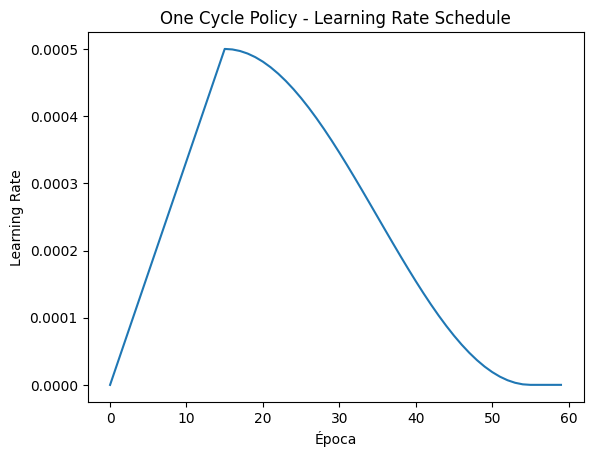

In [48]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

### Gráficas de entrenamiento y validación

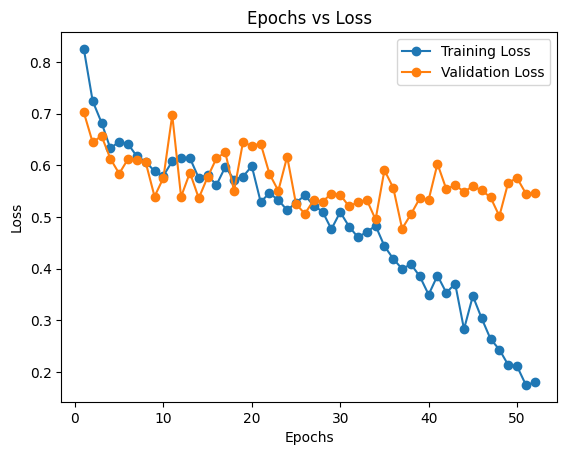

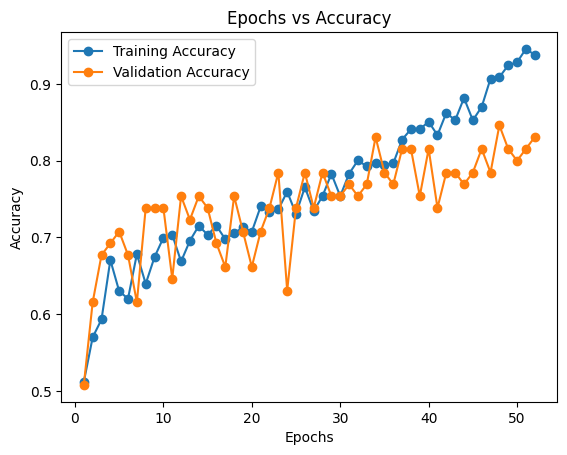

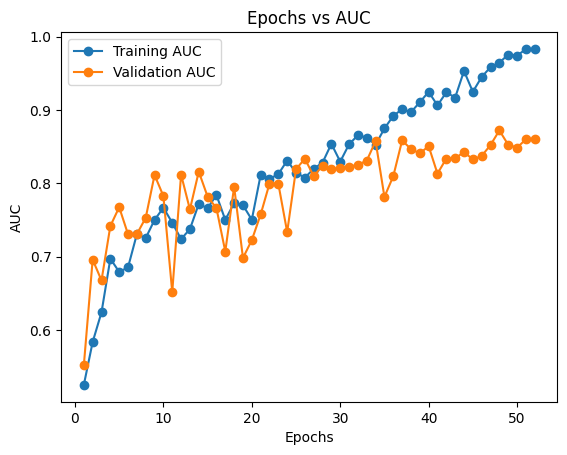

In [49]:
plot_loss(history_full2)
plot_accuracy(history_full2)
plot_auc(history_full2)

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


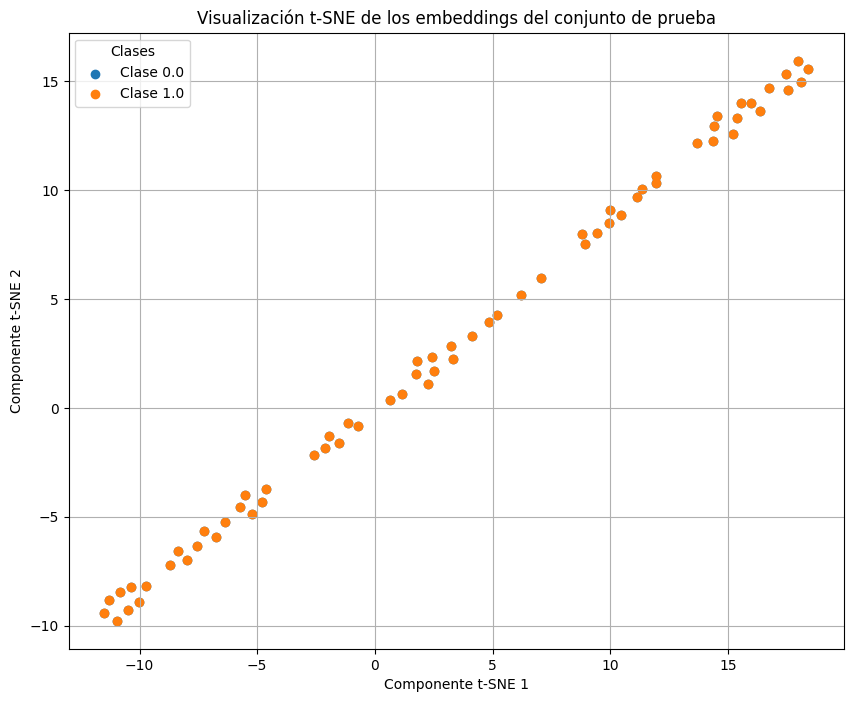

In [50]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

### Reconstrucción de modelos

In [24]:
from tensorflow.keras.metrics import AUC
try:
    # Carga el mejor modelo de cada uno 
    print("Cargando pesos de los modelos...")
    model_1.load_weights("checkpoints/i3d_model_1/epoch_20")
    model_2.load_weights("checkpoints/i3d_convlstm_1/best_model")
except:
    num_classes = 2
    # Clase adaptadora para usar InceptionI3D como modelo de Keras
    class KerasI3D(tf.keras.Model):
        def __init__(self, num_classes, endpoint = "Predictions"):
            super(KerasI3D, self).__init__()
            self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
            
        def call(self, inputs, training=False):
            logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
            return logits
    # Sacar el modelo 2 del tuner
    from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
    from tensorflow.keras import Model

    class I3D_ConvLSTM(tf.keras.Model):
        def __init__(self, num_classes):
            super(I3D_ConvLSTM, self).__init__()
            
            # Inception I3D
            self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint="Mixed_5c")
            
            # Hiperparámetros fijos ganados
            kernel_size = (3, 3)  # Ganado '3x3'
            filters = 128         # Ganado '128'
            dropout = 0.3         # Ganado '0.3'
            recurrent_dropout = 0.5  # Ganado '0.5'
            dense_units = 128     # Ganado '128'
            dense_dropout = 0.5   # Ganado '0.5'
            
            # ConvLSTM2D
            self.conv_lstm = ConvLSTM2D(
                filters=filters,
                kernel_size=kernel_size,
                padding='same',
                return_sequences=False,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                activation='tanh'
            )

            # Capa BatchNorm
            self.batch_norm = BatchNormalization()
            
            # Capa Dense
            self.dense = Dense(dense_units, activation='relu')
            
            # Dropout en Dense
            self.dropout = Dropout(dense_dropout)
            
            # Capa de salida
            self.fc = Dense(num_classes, activation='sigmoid')

        def call(self, inputs, training=False):
            # Pasa por InceptionI3D
            features, _ = self.i3d(inputs)
            
            # ConvLSTM
            x = self.conv_lstm(features)
            
            # Normalización y otras capas
            x = self.batch_norm(x, training=training)
            x = GlobalAveragePooling2D()(x)
            x = self.dense(x)
            x = self.dropout(x, training=training)
            
            # Capa de salida
            return self.fc(x)

    # Crear y compilar el modelo
    num_classes = 2    
    # Reconstruir el modelo1 para cargar los pesos    
    model_1 = KerasI3D(num_classes=num_classes)
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", AUC(name="auc")])
    # Cargar los pesos entrenados
    model_1.load_weights("checkpoints/i3d_model_1/best_model")

    # Reconstruir el modelo2 para cargar los pesos
    model_2 = I3D_ConvLSTM(num_classes=num_classes)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    # Cargar los pesos entrenados
    model_2.load_weights("checkpoints/i3d_model_1/best_model")

            

Cargando pesos de los modelos...


### Guardar modelo

In [75]:
import os
import glob
import shutil

def copy_best_model(origen_prefix, destino_dir):
    # Crear destino si no existe
    os.makedirs(destino_dir, exist_ok=True)

    # Mover todos los archivos que empiecen con 'best_model'
    for file in glob.glob(origen_prefix + '*'):
        destino_path = os.path.join(destino_dir, os.path.basename(file))
        if not os.path.exists(destino_path):
            shutil.copy2(file, destino_path)

    print(f"Archivos verificados/copiedos a: {destino_dir}")
    model_1.load_weights(os.path.join(destino_dir, 'best_model'))

In [76]:
# Ruta base y destino
origen_prefix = 'checkpoints/i3d_model_1/best_model'
destino_dir = '../models/saved_models/i3d_model_1/'

copy_best_model(origen_prefix, destino_dir)

Archivos verificados/copiedos a: ../models/saved_models/i3d_model_1/


In [77]:
# Ruta base y destino
origen_prefix = 'checkpoints/i3d_convlstm_1/best_model'
destino_dir = '../models/saved_models/i3d_convlstm_1/'

copy_best_model(origen_prefix, destino_dir)


Archivos verificados/copiedos a: ../models/saved_models/i3d_convlstm_1/


### Gráficas

In [26]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def evaluar_modelo(nombre, modelo, test_dataset):
    print('---------------------------------------------')
    print(f"Modelo {nombre}")
    
    # Obtener probabilidades
    y_prob = modelo.predict(test_dataset)
    y_pred = y_prob.argmax(axis=1)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset])

    if y_true.ndim == 1 or y_true.shape[1] == 1:
        num_classes = y_prob.shape[1]
        y_true_int = y_true.flatten()
        y_true_onehot = np.eye(num_classes)[y_true_int]
    else:
        y_true_onehot = y_true
        y_true_int = y_true.argmax(axis=1)

    # Reportes
    print("Classification Report:\n", classification_report(y_true_int, y_pred))

    # Matriz de confusión mejorada
    cm = confusion_matrix(y_true_int, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # AUC-ROC
    auc = roc_auc_score(y_true_onehot, y_prob, multi_class='ovr')
    print(f"AUC (One-vs-Rest): {auc:.4f}")
    
    # Curvas ROC por clase
    plt.figure(figsize=(8, 6))
    for i in range(y_prob.shape[1]):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Clase {i}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title("Curva ROC por clase")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Histograma de probabilidades predichas por clase real
    plt.figure(figsize=(8, 6))
    for clase in np.unique(y_true_int):
        probs_clase = y_prob[y_true_int == clase, clase]
        plt.hist(probs_clase, bins=20, alpha=0.6, label=f"Clase {clase}")
    plt.title("Distribución de Probabilidades Predichas")
    plt.xlabel("Probabilidad de la clase correcta")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evolución tasa Falsos Positivos y Falsos Negativos
    thresholds = np.linspace(0, 1, 100)
    fpr_list = []
    fnr_list = []

    for thresh in thresholds:
        y_thresh_pred = (y_prob.max(axis=1) >= thresh).astype(int) * y_pred
        cm_thresh = confusion_matrix(y_true_int, y_thresh_pred, labels=range(y_prob.shape[1]))
        FP = cm_thresh.sum(axis=0) - np.diag(cm_thresh)
        FN = cm_thresh.sum(axis=1) - np.diag(cm_thresh)
        TP = np.diag(cm_thresh)
        TN = cm_thresh.sum() - (FP + FN + TP)

        fpr = FP.sum() / (FP.sum() + TN.sum() + 1e-10)
        fnr = FN.sum() / (FN.sum() + TP.sum() + 1e-10)

        fpr_list.append(fpr)
        fnr_list.append(fnr)

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, fpr_list, label="Falsos Positivos")
    plt.plot(thresholds, fnr_list, label="Falsos Negativos")
    plt.xlabel("Umbral de decisión")
    plt.ylabel("Tasa")
    plt.title("Evolución de Falsos Positivos y Falsos Negativos")
    plt.legend()
    plt.grid(True)
    plt.show()


In [28]:
def comparar_auc(modelo_1, modelo_2, test_dataset):
    print('---------------------------------------------')
    print("Comparación de AUC - Curva ROC General")

    y_prob_1 = modelo_1.predict(test_dataset)
    y_prob_2 = modelo_2.predict(test_dataset)
    y_true = np.concatenate([y.numpy() for _, y in test_dataset])

    if y_true.ndim == 1 or y_true.shape[1] == 1:
        y_true = y_true.flatten()
        y_score_1 = y_prob_1[:, 1] if y_prob_1.shape[1] > 1 else y_prob_1[:, 0]
        y_score_2 = y_prob_2[:, 1] if y_prob_2.shape[1] > 1 else y_prob_2[:, 0]

        fpr1, tpr1, _ = roc_curve(y_true, y_score_1)
        fpr2, tpr2, _ = roc_curve(y_true, y_score_2)

        auc1 = auc(fpr1, tpr1)
        auc2 = auc(fpr2, tpr2)

        # Buscar punto donde TPR ≈ 1 - FPR
        idx1 = np.argmin(np.abs(tpr1 - (1 - fpr1)))
        idx2 = np.argmin(np.abs(tpr2 - (1 - fpr2)))

        punto_eq_1 = (fpr1[idx1], tpr1[idx1])
        punto_eq_2 = (fpr2[idx2], tpr2[idx2])
    else:
        y_true_int = y_true.argmax(axis=1)
        y_true_onehot = y_true
        auc1 = roc_auc_score(y_true_onehot, y_prob_1, multi_class='ovr')
        auc2 = roc_auc_score(y_true_onehot, y_prob_2, multi_class='ovr')

        fpr1, tpr1, _ = roc_curve(y_true_onehot.ravel(), y_prob_1.ravel())
        fpr2, tpr2, _ = roc_curve(y_true_onehot.ravel(), y_prob_2.ravel())

        idx1 = np.argmin(np.abs(tpr1 - (1 - fpr1)))
        idx2 = np.argmin(np.abs(tpr2 - (1 - fpr2)))

        punto_eq_1 = (fpr1[idx1], tpr1[idx1])
        punto_eq_2 = (fpr2[idx2], tpr2[idx2])

    print(f"AUC Modelo 1: {auc1:.4f}")
    print(f"AUC Modelo 2: {auc2:.4f}")

    # Graficar curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, label=f'Modelo 1 (AUC = {auc1:.2f})', linestyle='--')
    plt.plot(fpr2, tpr2, label=f'Modelo 2 (AUC = {auc2:.2f})', linestyle='-')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    # Marcar el punto donde TPR ≈ 1 - FPR
    plt.plot(*punto_eq_1, 'o', label='TPR=1-FPR (Modelo 1)', color='blue')
    plt.plot(*punto_eq_2, 'o', label='TPR=1-FPR (Modelo 2)', color='orange')

    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curva ROC - Comparación General de Modelos")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


---------------------------------------------
Modelo I3D


2025-05-02 02:16:01.707695: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-05-02 02:16:01.726292: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2025-05-02 02:16:14.877230: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2025-05-02 02:16:15.608511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2025-05-02 02:16:16.467435: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-02 02:16:16.467485: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2025-05-02 02:16:16.468657: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-02 02:16:16.468705: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.62        33
           1       0.62      0.66      0.64        32

    accuracy                           0.63        65
   macro avg       0.63      0.63      0.63        65
weighted avg       0.63      0.63      0.63        65



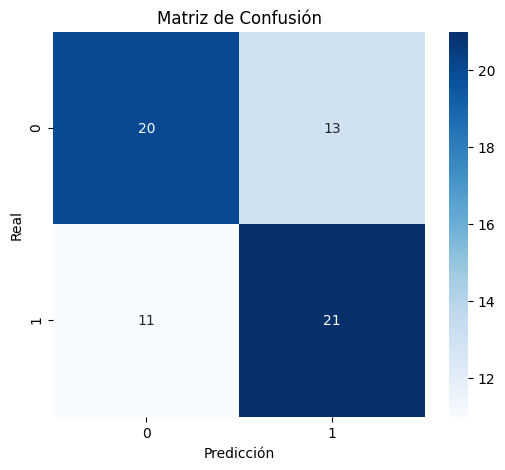

AUC (One-vs-Rest): 0.6430


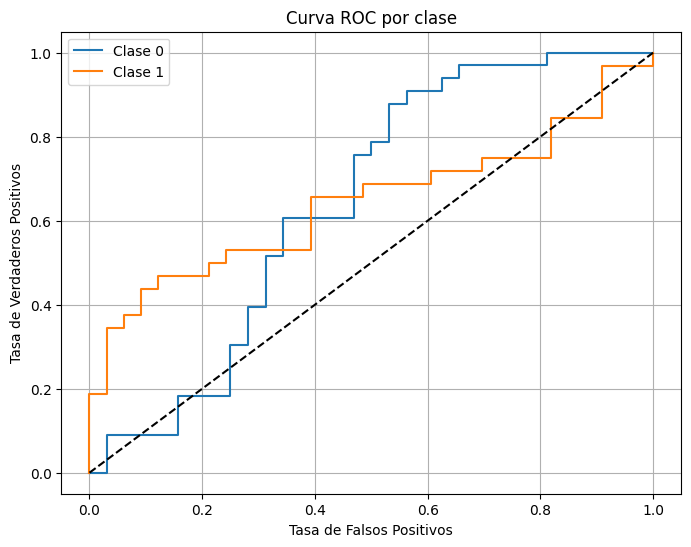

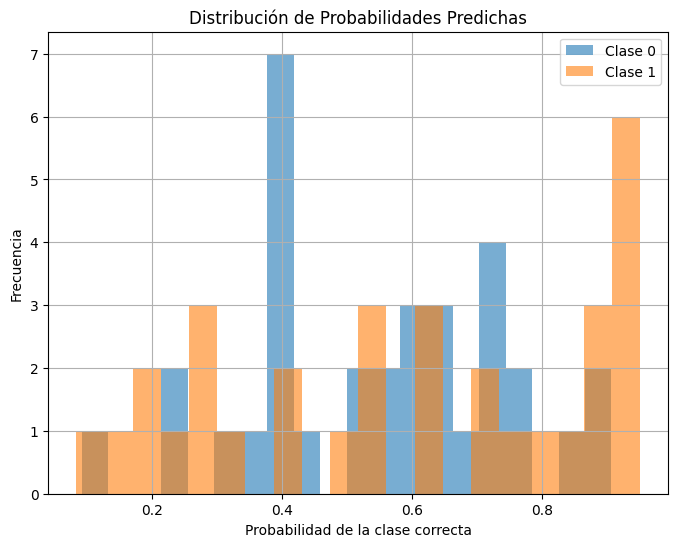

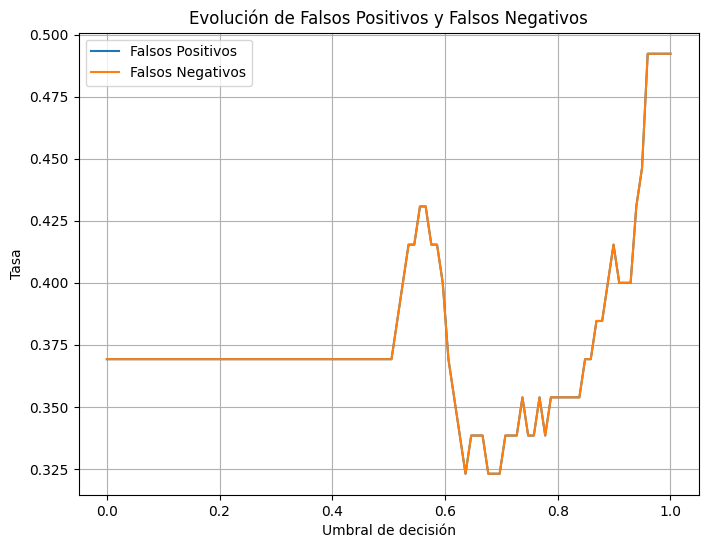

In [28]:
# Evaluar ambos modelos
evaluar_modelo("I3D", model_1, test_dataset)


---------------------------------------------
Modelo I3D+ConvLSTM


2025-05-02 02:04:19.446884: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70        33
           1       0.69      0.62      0.66        32

    accuracy                           0.68        65
   macro avg       0.68      0.68      0.68        65
weighted avg       0.68      0.68      0.68        65



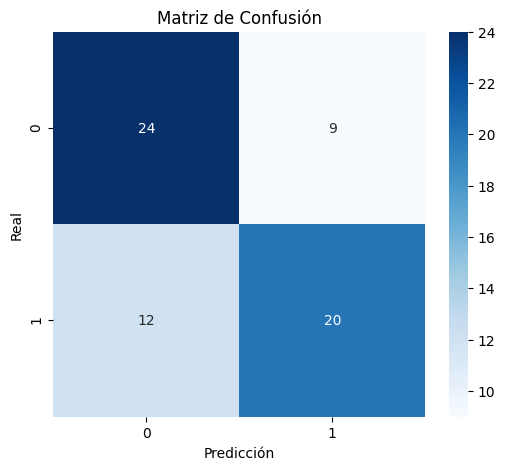

AUC (One-vs-Rest): 0.7325


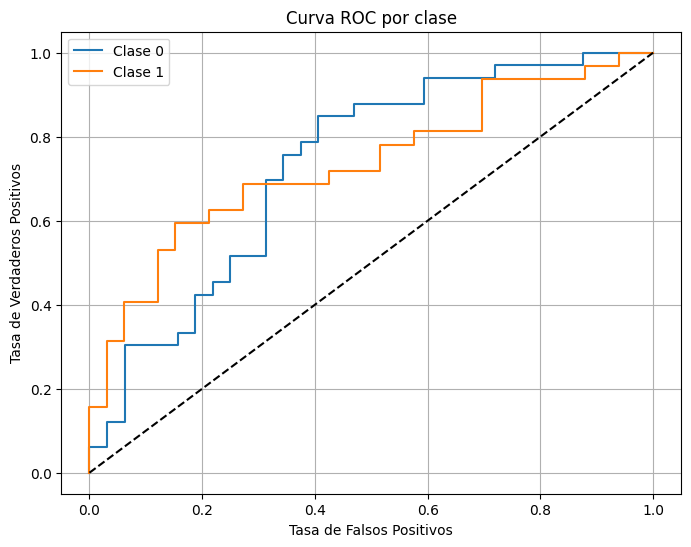

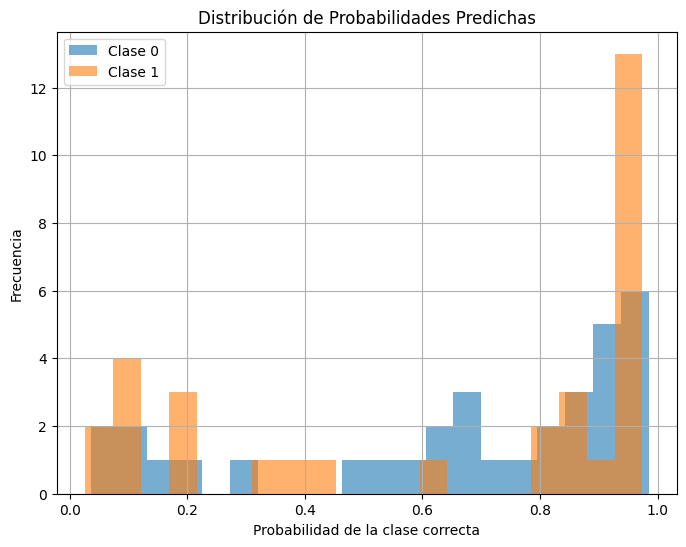

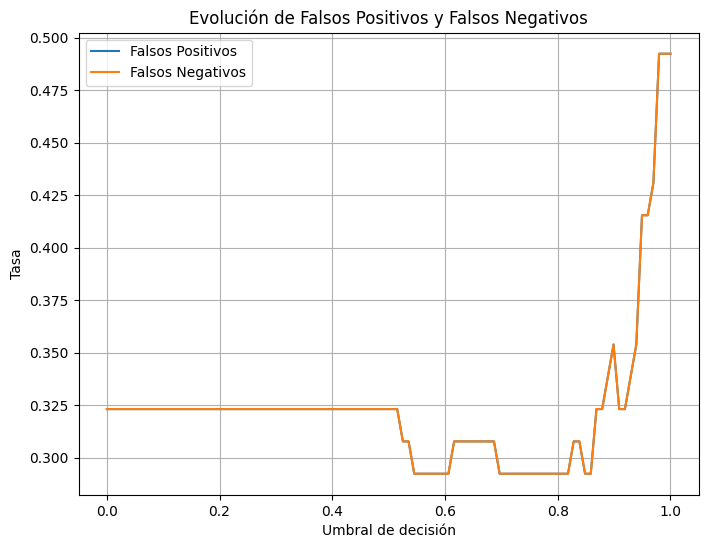

In [42]:
evaluar_modelo("I3D+ConvLSTM", model_2, test_dataset)

---------------------------------------------
Comparación de AUC - Curva ROC General


2025-05-02 02:38:50.644755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-05-02 02:38:50.662275: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2100000000 Hz
2025-05-02 02:39:03.033723: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2025-05-02 02:39:03.750573: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2025-05-02 02:39:04.642564: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-02 02:39:04.642597: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2025-05-02 02:39:04.643707: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-02 02:39:04.643753: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

AUC Modelo 1: 0.6430
AUC Modelo 2: 0.7325


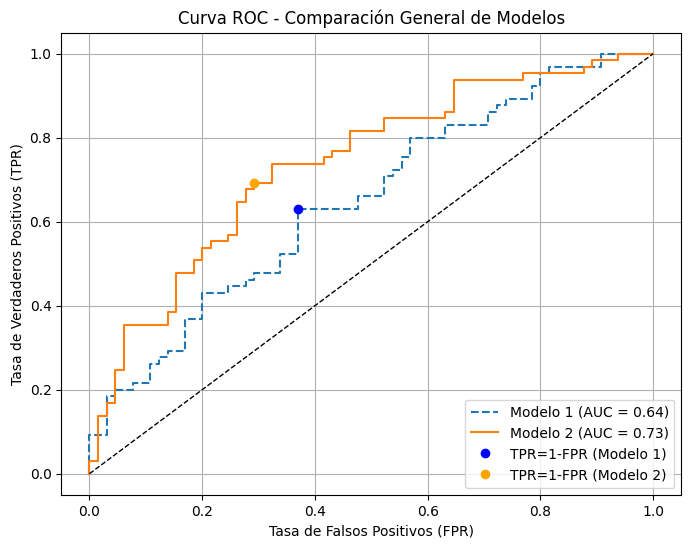

In [29]:
comparar_auc(model_1, model_2, test_dataset)

### Pesos

In [43]:
def pesos(model):
    model.summary()
    # Total de pesos entrenables
    trainable_count = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    print("Trainable weights:", trainable_count)

    # Pesos no entrenables
    non_trainable_count = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    print("Non-trainable weights:", non_trainable_count)

In [44]:
print('-'*60)
print("Pesos del modelo 1:")
pesos(model_1)
print('-'*60)
print("\nPesos del modelo 2:")
pesos(model_2)

------------------------------------------------------------
Pesos del modelo 1:
Model: "keras_i3d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 12,318,550
Trainable params: 12,282,034
Non-trainable params: 36,516
_________________________________________________________________
Trainable weights: 12282034
Non-trainable weights: 36516.0
------------------------------------------------------------

Pesos del modelo 2:
Model: "tuned__i3d__conv_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  multiple                  5308928   
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
dense_2 (Dense)              multiple            

2025-05-02 02:04:59.383900: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Visualización del modelo

keras summary
cuantos videos entrenaron i3d
cuantos pesos se entrena
diagrama de bloques
demo en lighting 
